# By-phone error rates: Buckeye test set
This computes and compares error rates and confusion matrices at the phone level across different models' predicted transcriptions in the Buckeye test set. This helps us understand which phones are most frequently mistaken by the models we're interested in. Conversely, can also see which phones we're performing well on.

In [1]:
import collections
from pathlib import Path
import re

import ipatok
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phonecodes import phonecode_tables
import seaborn as sns

from multipa.evaluation import ModelEvaluator, PREDICTION_KEY, EPS, compute_error_rate_confidence_intervals_df
from multipa.visualization import plot_error_rates_by_phone_and_model, plot_token_confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

TOKEN_ANALYSIS_OUTPUT = "buckeye_test_token_analysis.csv"
DETAILED_EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")
# These are the models we're actually interested in evaluating in detail
DETAILED_EVAL_CSVS = [
    # Models trained on full 20K samples (full dataset but gender balanced)
    "data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Models trained on entire dataset
    "ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Third party comparison models
    #"openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    "allosaurus_eng2102_eng_detailed_predictions.csv",
    #"facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_detailed_predictions.csv",
]

REFERENCE_COL = "ipa"

VALID_BUCKEYE_PHONES = set(phonecode_tables._buckeye2ipa.values())

# This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
BUCKEYE_VOWELS = set(["ɑ", "æ", "ʌ", "ɔ", "aʊ", "aɪ", "ɛ", "ɹ̩", "eɪ", "ɪ", "i", "oʊ", "ɔɪ", "ʊ", "u", "æ̃", "ɔ̃",
                  "ə̃", "ĩ", "ẽɪ̃", "õʊ̃", "ãɪ̃", "ɑ̃", "ũ", "ɾ̃", "ə", "ɛ̃", "ʊ̃", "ãʊ̃", "ʌ̃", "ɪ̃", "ɹ̩̃", "ɔ̃ɪ̃"])

BUCKEYE_CONSONANTS = VALID_BUCKEYE_PHONES - BUCKEYE_VOWELS

# I'm just being picky about plot colors
HUE_ORDER = ["full_dataset_train", "train_duration_20000_samples",
"excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k", "openai_whisper-medium.en_to_epitran", "allosaurus_eng2102_eng", "facebook_wav2vec2-lv-60-espeak-cv-ft", "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns"]

HUE_ORDER_INDEX = {key: i for i, key in enumerate(HUE_ORDER)}

PALETTE = "colorblind"

sns.set_palette(PALETTE)

def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, VALID_BUCKEYE_PHONES)

def get_model_group(model_name):
    for p in ["train_duration_20000_samples", "full_dataset_train"]:
        if model_name.startswith(p):
            return p
    return model_name



/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Post-process predictions and evaluations
Read in evaluation results, tokenize, and calculate token counts and edit distance errors for each model. 


In [2]:
# Read in model results and re-generate comparison metrics
MODEL_EVALUATOR = ModelEvaluator(tokenise_options={"diphthongs":True, "merge":buckeye_merge_func})

# Will use to make a dataframe that we can pivot to compare model vocabulary by token counts
# in Buckeye test set predictions across models
model_token_counts = []
model_names = []

for csv in DETAILED_EVAL_CSVS:
    print("Processing", csv)
    if csv.startswith("data_models_train_duration"):
        model_name = re.search(r'train_duration_20000_samples_[1-5]', csv).group()
    elif csv.startswith("ginic_full_dataset_train"):
        model_name = re.search(r'full_dataset_train_[1-5]', csv).group()
    else:
        model_name = csv.removesuffix("_detailed_predictions.csv")
    model_results = pd.read_csv(
            DETAILED_EVAL_PATH / csv,
            dtype={PREDICTION_KEY: str, REFERENCE_COL: str},
            keep_default_na=False
        )
    model_names.append(model_name)
    latest_ref_col = model_results[REFERENCE_COL]
    MODEL_EVALUATOR.eval_edit_distances(model_name, model_results[PREDICTION_KEY], latest_ref_col, compute_by_token_error_rates=True)

    model_token_counts.extend([(model_name, t, c) for t,c in MODEL_EVALUATOR._true_token_counts[model_name].items()])

model_token_counts_df = pd.DataFrame(model_token_counts, columns=["model_name", "token", "count"])

Processing data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_5_

In [3]:
display(model_token_counts_df.head())

model_name token  count
0  train_duration_20000_samples_1     f   2348
1  train_duration_20000_samples_1     ɔ   1720
2  train_duration_20000_samples_1     ɹ   6185
3  train_duration_20000_samples_1    aɪ   4201
4  train_duration_20000_samples_1     v   2329

In [4]:
# Sanity check token counts in the gold-standard labels against actual vocabulary
# The invalid token warnings are harmless, it's just removing some "NOISE" and disfluency markers that snuck through
# data preprocessing, but don't affect training
final_token_counts = {t:0 for t in VALID_BUCKEYE_PHONES}

tokens = []
for ref in latest_ref_col:
    tokens.extend(ipatok.tokenise(ref, diphthongs=True, merge = buckeye_merge_func))

test_token_counts = collections.Counter(tokens)
final_token_counts.update(test_token_counts)

for t in list(final_token_counts.keys()):
    if t not in VALID_BUCKEYE_PHONES:
        print("REMOVING INVALID TOKEN:", t, t.encode("unicode-escape"))
        del final_token_counts[t]

token_counts_df = pd.DataFrame.from_records(
        list(final_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)

display(token_counts_df)

REMOVING INVALID TOKEN: õ b'o\\u0303'
REMOVING INVALID TOKEN: O b'O'
REMOVING INVALID TOKEN: I b'I'
REMOVING INVALID TOKEN: E b'E'
REMOVING INVALID TOKEN: A b'A'
REMOVING INVALID TOKEN: U b'U'
REMOVING INVALID TOKEN: H b'H'


phone  counts
2      ʌ   14477
40     ɪ   12433
50     n    9310
62     s    8389
29     ɛ    6829
17     i    6631
44     t    6465
23     ɹ    6185
11     k    5349
61     l    5348
52     m    4917
14     d    4450
42    aɪ    4201
36     ð    3966
12     w    3965
55    oʊ    3788
19     z    3527
41     j    3408
16     æ    3302
18    ɹ̩    3088
35    eɪ    3035
59     b    2968
56     ɾ    2808
30     ɑ    2737
9      p    2530
53     f    2348
4      v    2329
34     u    2325
58     ʔ    2294
25    ɾ̃    2269
28     h    2079
26     ɡ    1876
13     ɔ    1720
33     ŋ    1586
39     θ    1494
37    n̩    1286
10     ʊ    1085
43     ʃ    1071
57    aʊ     975
38    dʒ     923
15    tʃ     918
31    l̩     727
49    m̩     512
60     ʒ     160
51    ʊ̃     124
7     ɔɪ     105
5     ʌ̃      89
8     ɪ̃      74
1     ɛ̃      72
20    æ̃      67
54    ĩ      28
46    ɑ̃      28
0   ãʊ̃      23
3      β      15
32  ãɪ̃      15
22  ẽɪ̃      13
24  ɔ̃ɪ̃       9
27    ɔ̃       6
47    ũ       1
21    ə̃       0
48     ə       0
6    ɹ̩̃       0
45   õʊ̃       0

In [5]:
# Munge data into dataframe format for analysis
records = []
for model_name, eval_results in MODEL_EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[MODEL_EVALUATOR.by_token_error_rates].items():
        if phone in VALID_BUCKEYE_PHONES:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=["model_name", "phone", "err_rate"])
all_error_rates_df["model_group"] = all_error_rates_df["model_name"].apply(get_model_group)

all_error_rates_df = compute_error_rate_confidence_intervals_df(all_error_rates_df,token_counts_df, "phone", "phone", "err_rate", "counts")

In [6]:
display(all_error_rates_df.head())

model_name phone  err_rate  \
0  train_duration_20000_samples_1     f  0.084753   
1  train_duration_20000_samples_2     f  0.116269   
2  train_duration_20000_samples_3     f  0.078790   
3  train_duration_20000_samples_4     f  0.076235   
4  train_duration_20000_samples_5     f  0.087308   

                    model_group  counts  confidence_interval  
0  train_duration_20000_samples    2348             0.011266  
1  train_duration_20000_samples    2348             0.012966  
2  train_duration_20000_samples    2348             0.010897  
3  train_duration_20000_samples    2348             0.010734  
4  train_duration_20000_samples    2348             0.011418

# By-token error rates
Display each model's error rates for each token.

<Axes: title={'center': 'Error rates for consonants on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

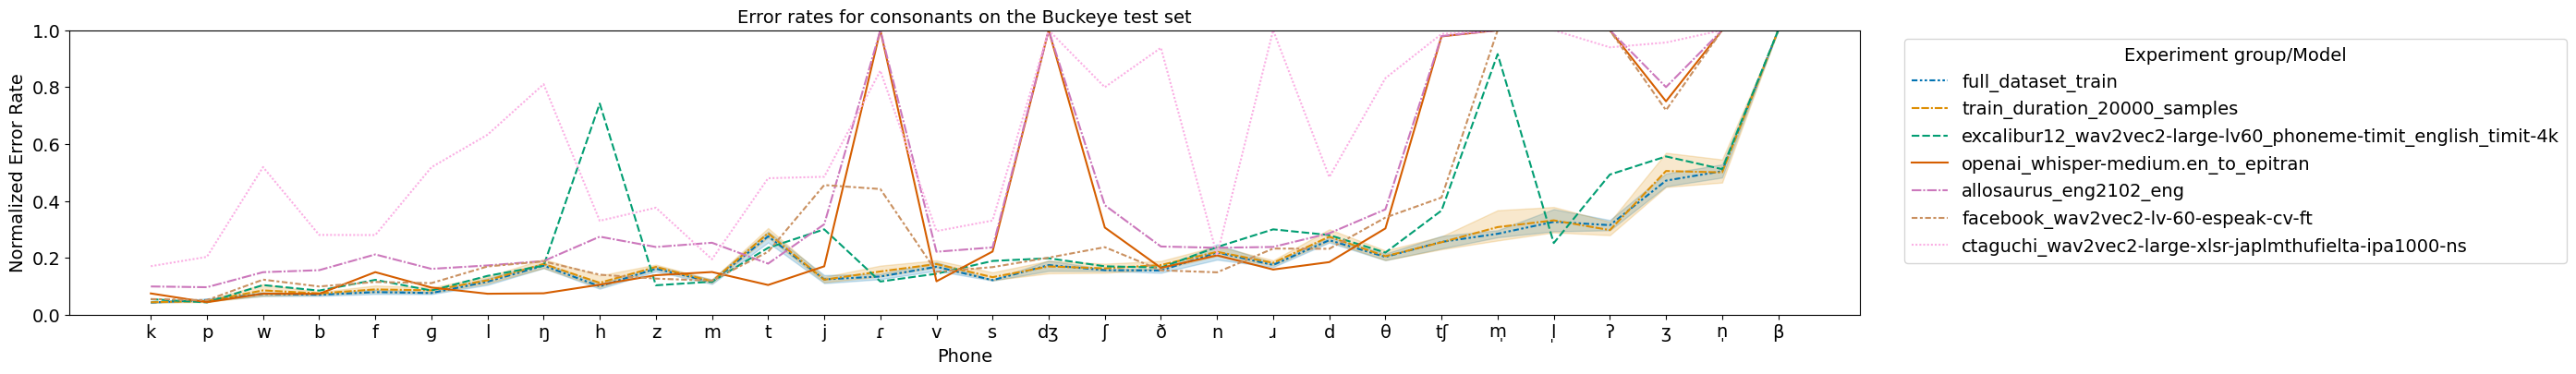

In [7]:
consonant_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(consonant_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for consonants on the Buckeye test set")

<Axes: title={'center': 'Error rates for vowels on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

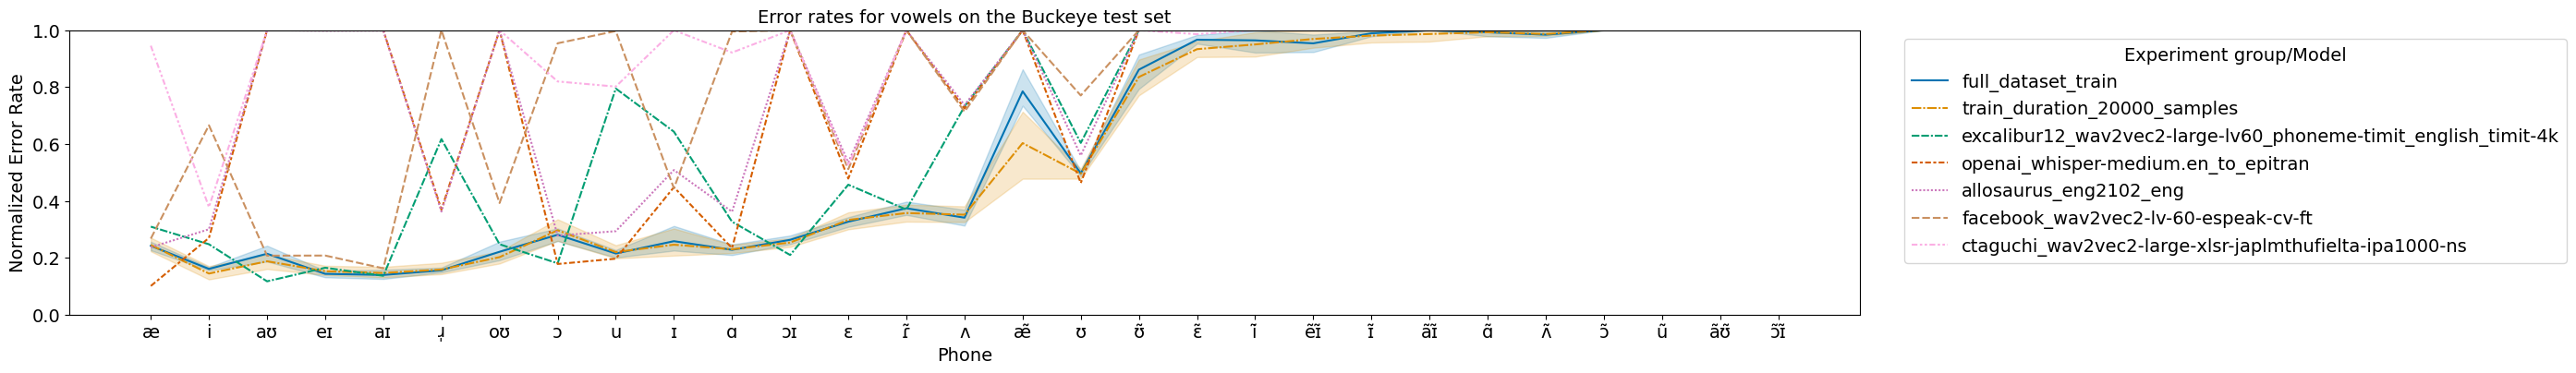

In [8]:
vowel_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(vowel_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for vowels on the Buckeye test set")

In [9]:
our_models = all_error_rates_df[all_error_rates_df["model_group"].isin(["train_duration_20000_samples", "full_dataset_train"])]
model_orders = [f"train_duration_20000_samples_{i}" for i in range(1, 6)] + [f"full_dataset_train_{i}" for i in range(1, 6)]

<Axes: title={'center': 'AutoIPA model error rates for consonants on the Buckeye test set\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

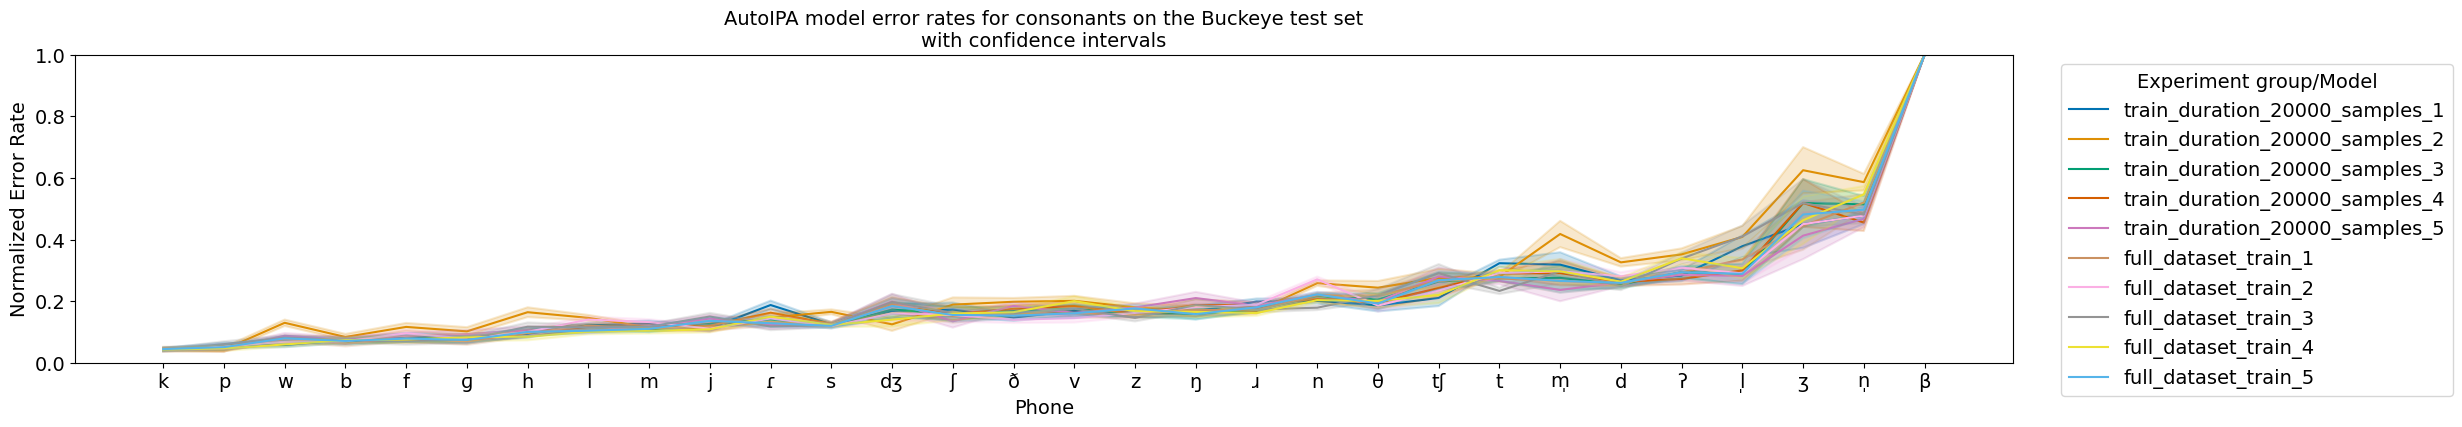

In [10]:
our_models_consonants = our_models[our_models["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(our_models_consonants, "model_name", hue_order = model_orders, palette=PALETTE, title="AutoIPA model error rates for consonants on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True)

<Axes: title={'center': 'AutoIPA model error rates for consonants on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

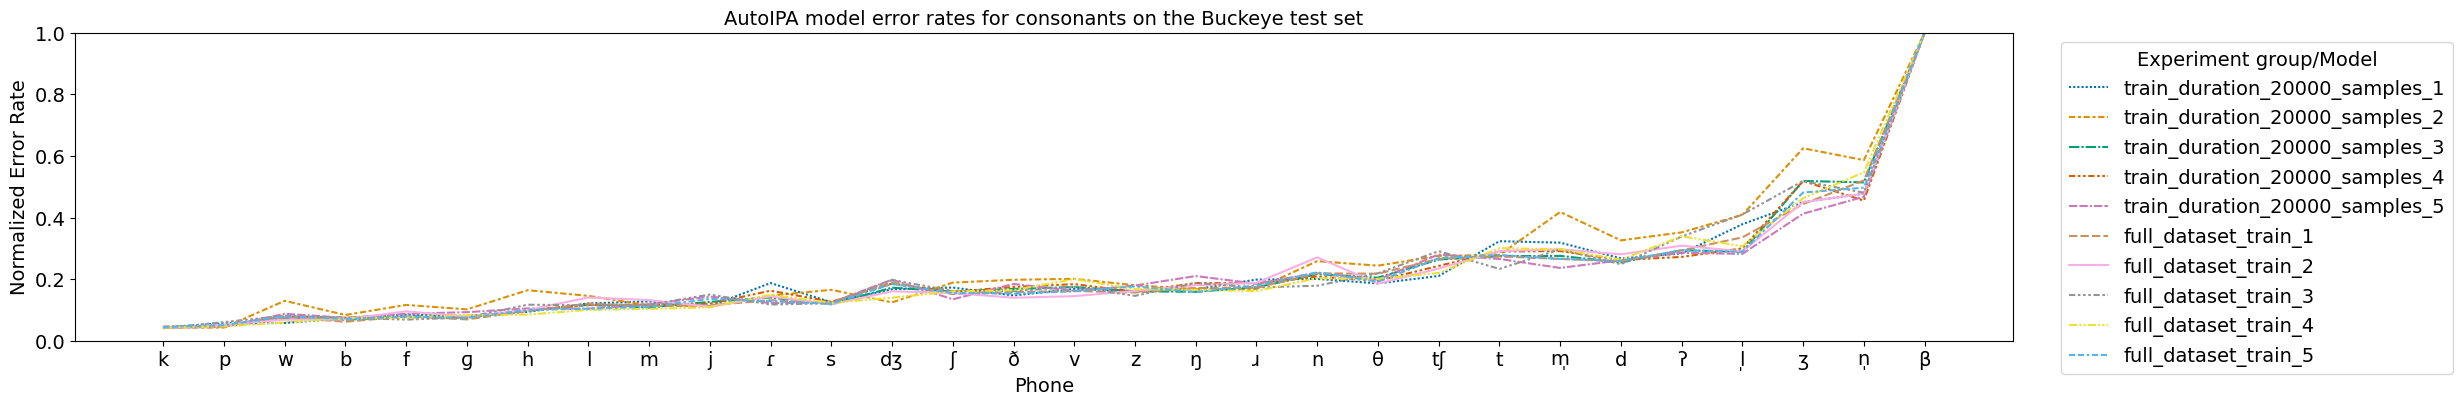

In [11]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_name", hue_order = model_orders, palette=PALETTE, title="AutoIPA model error rates for consonants on the Buckeye test set")

<Axes: title={'center': 'AutoIPA model error rates for vowels on the Buckeye test set\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

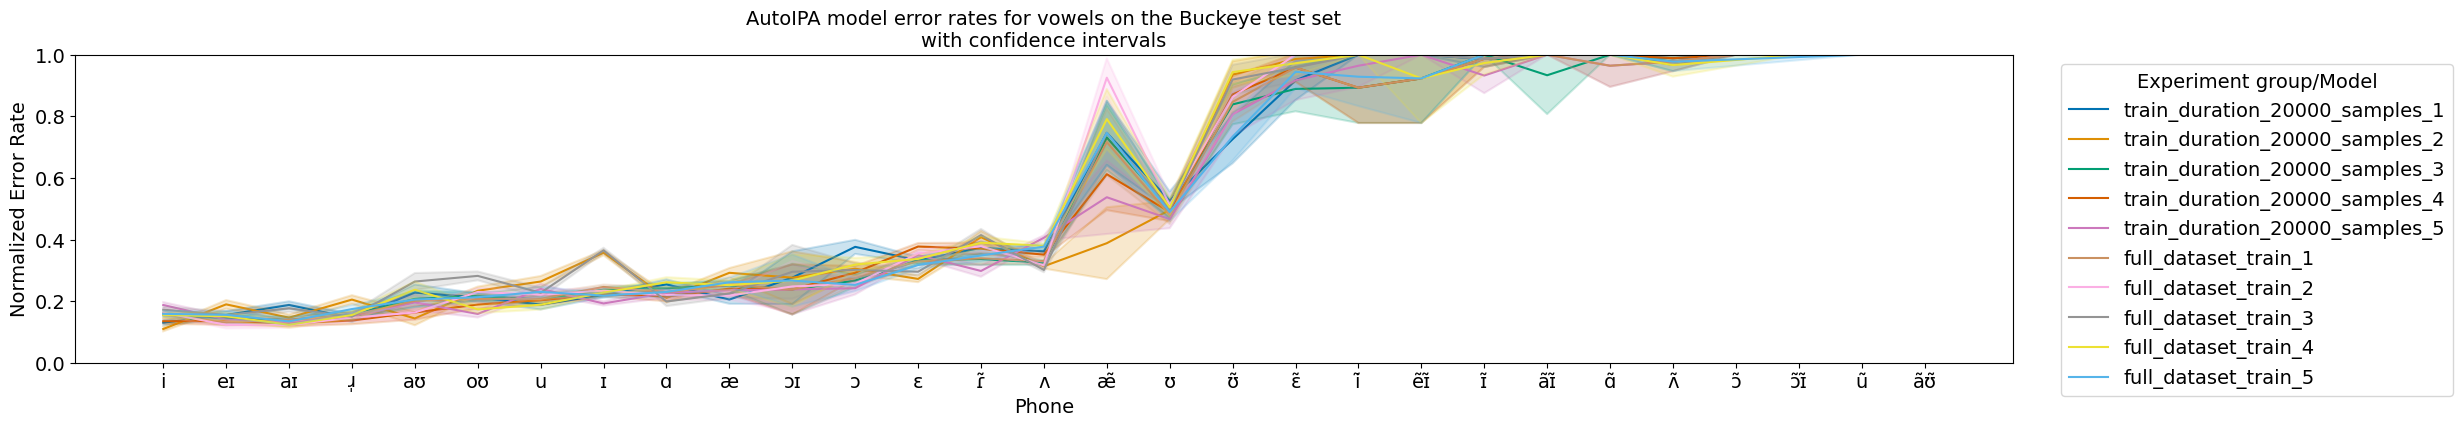

In [12]:
our_models_vowels = our_models[our_models["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(our_models_vowels, "model_name", hue_order = model_orders, palette=PALETTE, title="AutoIPA model error rates for vowels on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True, )

<Axes: title={'center': 'AutoIPA model error rates for vowels on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

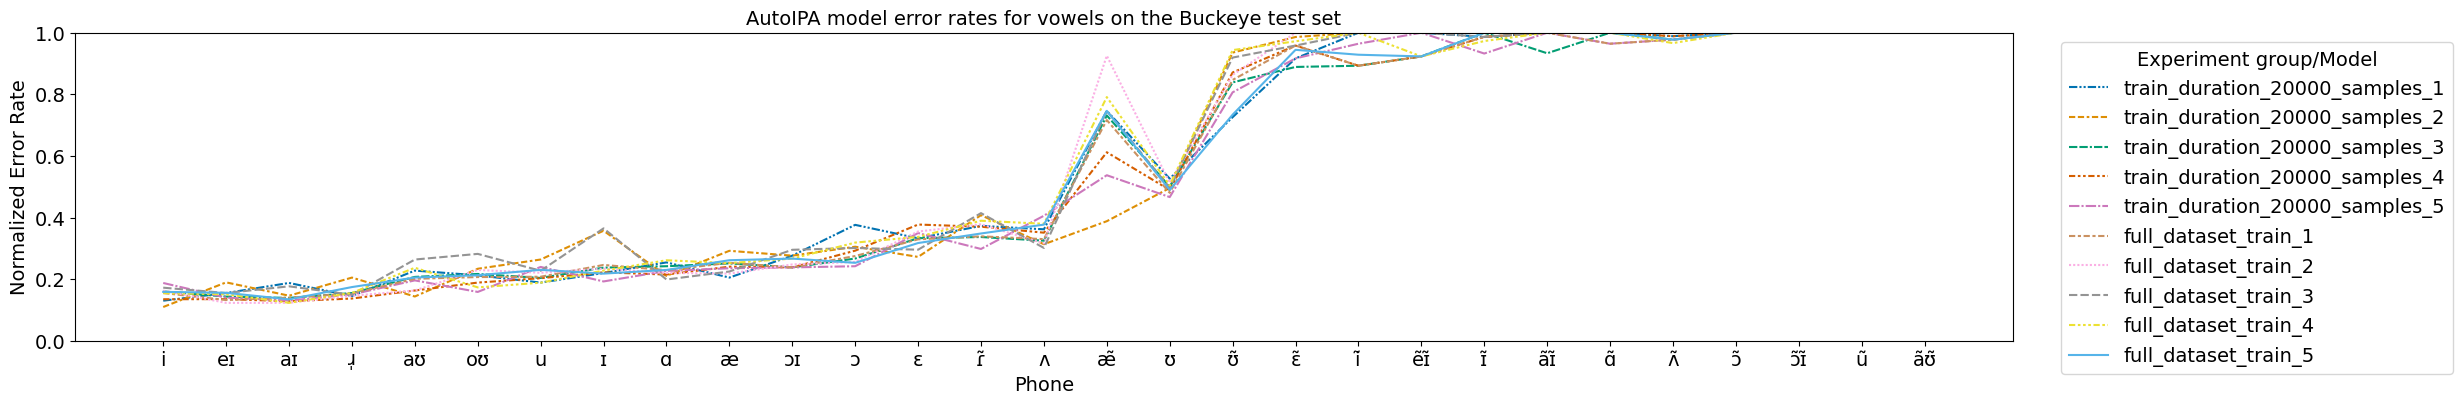

In [13]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_name", palette=PALETTE, title="AutoIPA model error rates for vowels on the Buckeye test set", hue_order = model_orders)

<Axes: title={'center': 'Error rates for consonants on the Buckeye test\naveraged across AutoIPA experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

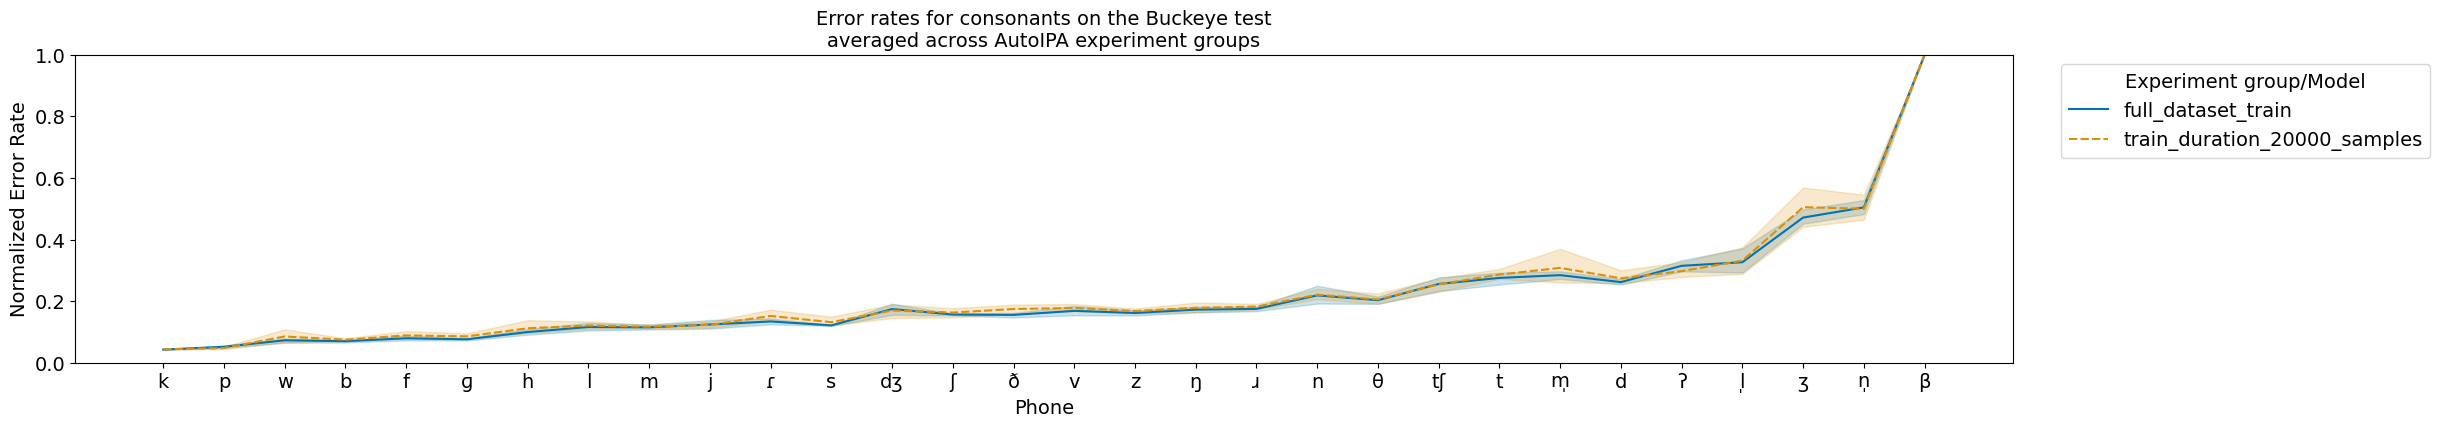

In [14]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_group",  hue_order=["full_dataset_train", "train_duration_20000_samples"], palette=PALETTE, title="Error rates for consonants on the Buckeye test\naveraged across AutoIPA experiment groups",)

<Axes: title={'center': 'Error rates for vowels on the Buckeye test\naveraged across AutoIPA experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

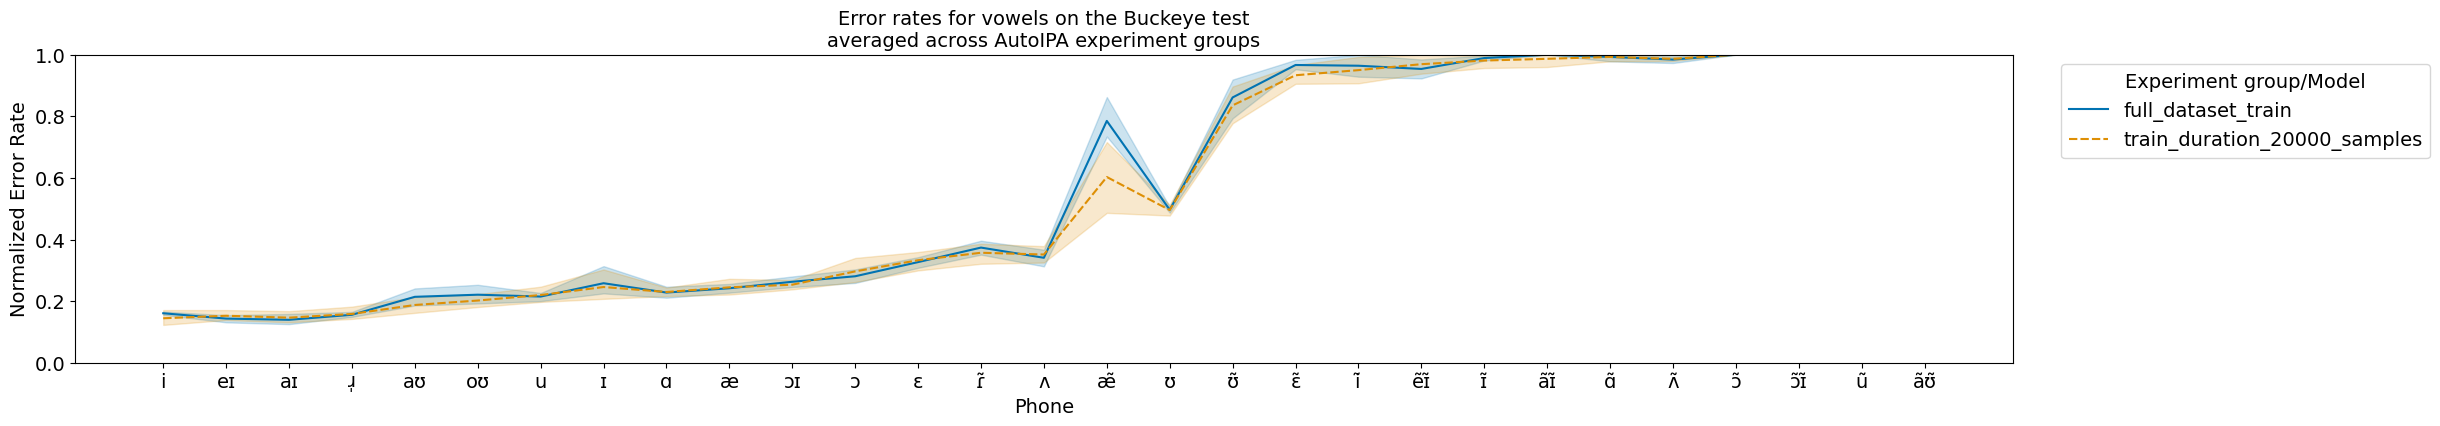

In [15]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_group", hue_order=["full_dataset_train", "train_duration_20000_samples"], palette=PALETTE, title="Error rates for vowels on the Buckeye test\naveraged across AutoIPA experiment groups",)

# Confusion matrices
Get the confusion matrix for each model's errors. Display confusion matrix separated by consonants and vowels separately for a few select models. 

In [16]:
# Gets the confusion matrix for each model
conf_matrices = {}
for mn in model_names:
    print("Model name:", mn)
    conf_matrices[mn] = MODEL_EVALUATOR.get_token_confusion_matrix(mn)


Model name: train_duration_20000_samples_1
Model name: train_duration_20000_samples_2
Model name: train_duration_20000_samples_3
Model name: train_duration_20000_samples_4
Model name: train_duration_20000_samples_5
Model name: full_dataset_train_1
Model name: full_dataset_train_2
Model name: full_dataset_train_3
Model name: full_dataset_train_4
Model name: full_dataset_train_5
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k


<Figure size 640x480 with 0 Axes>

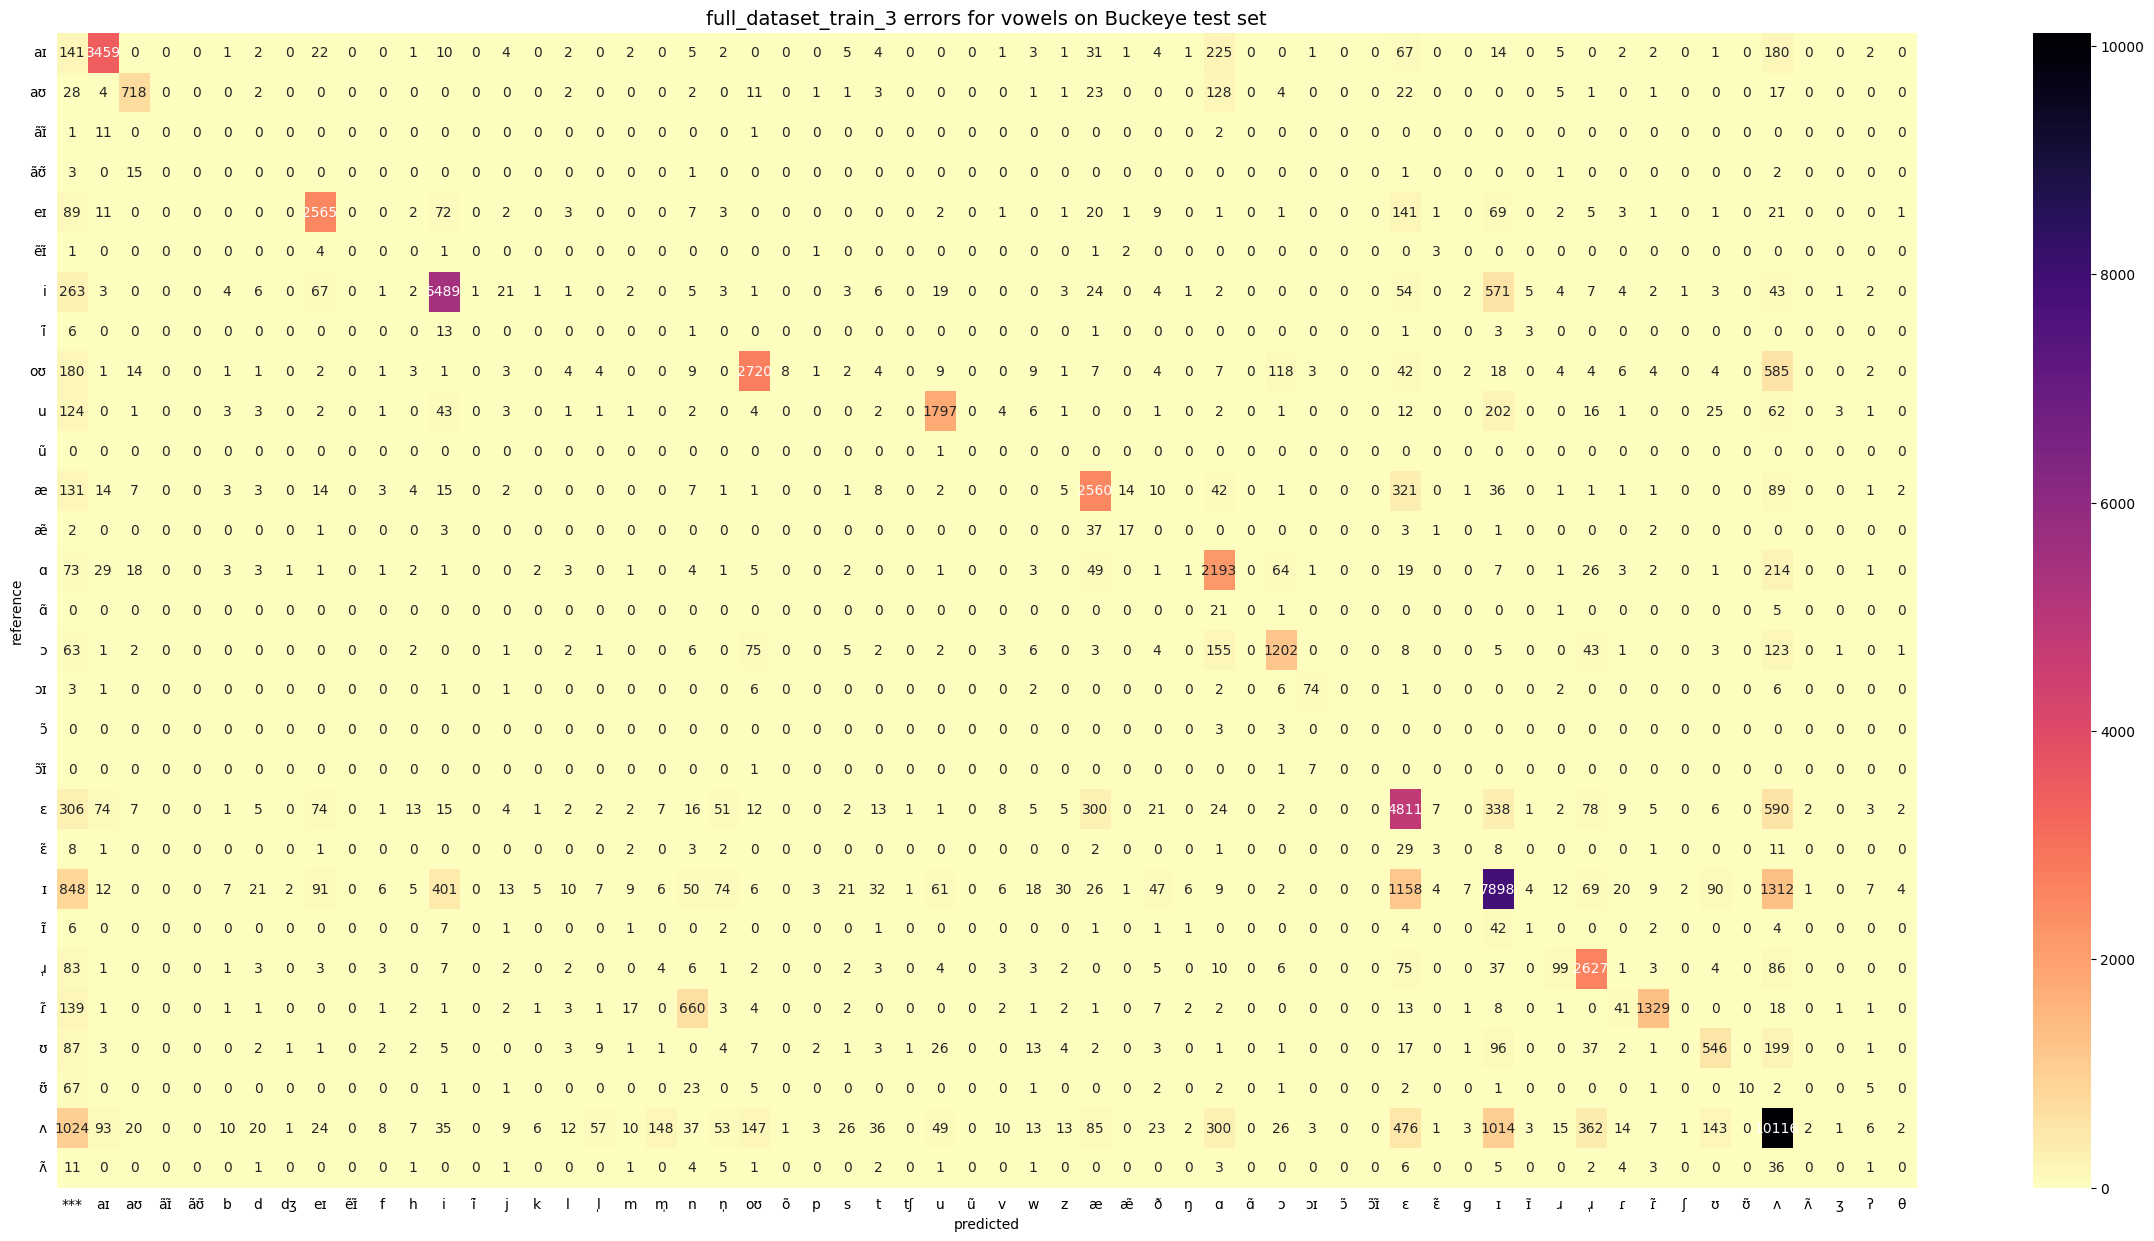

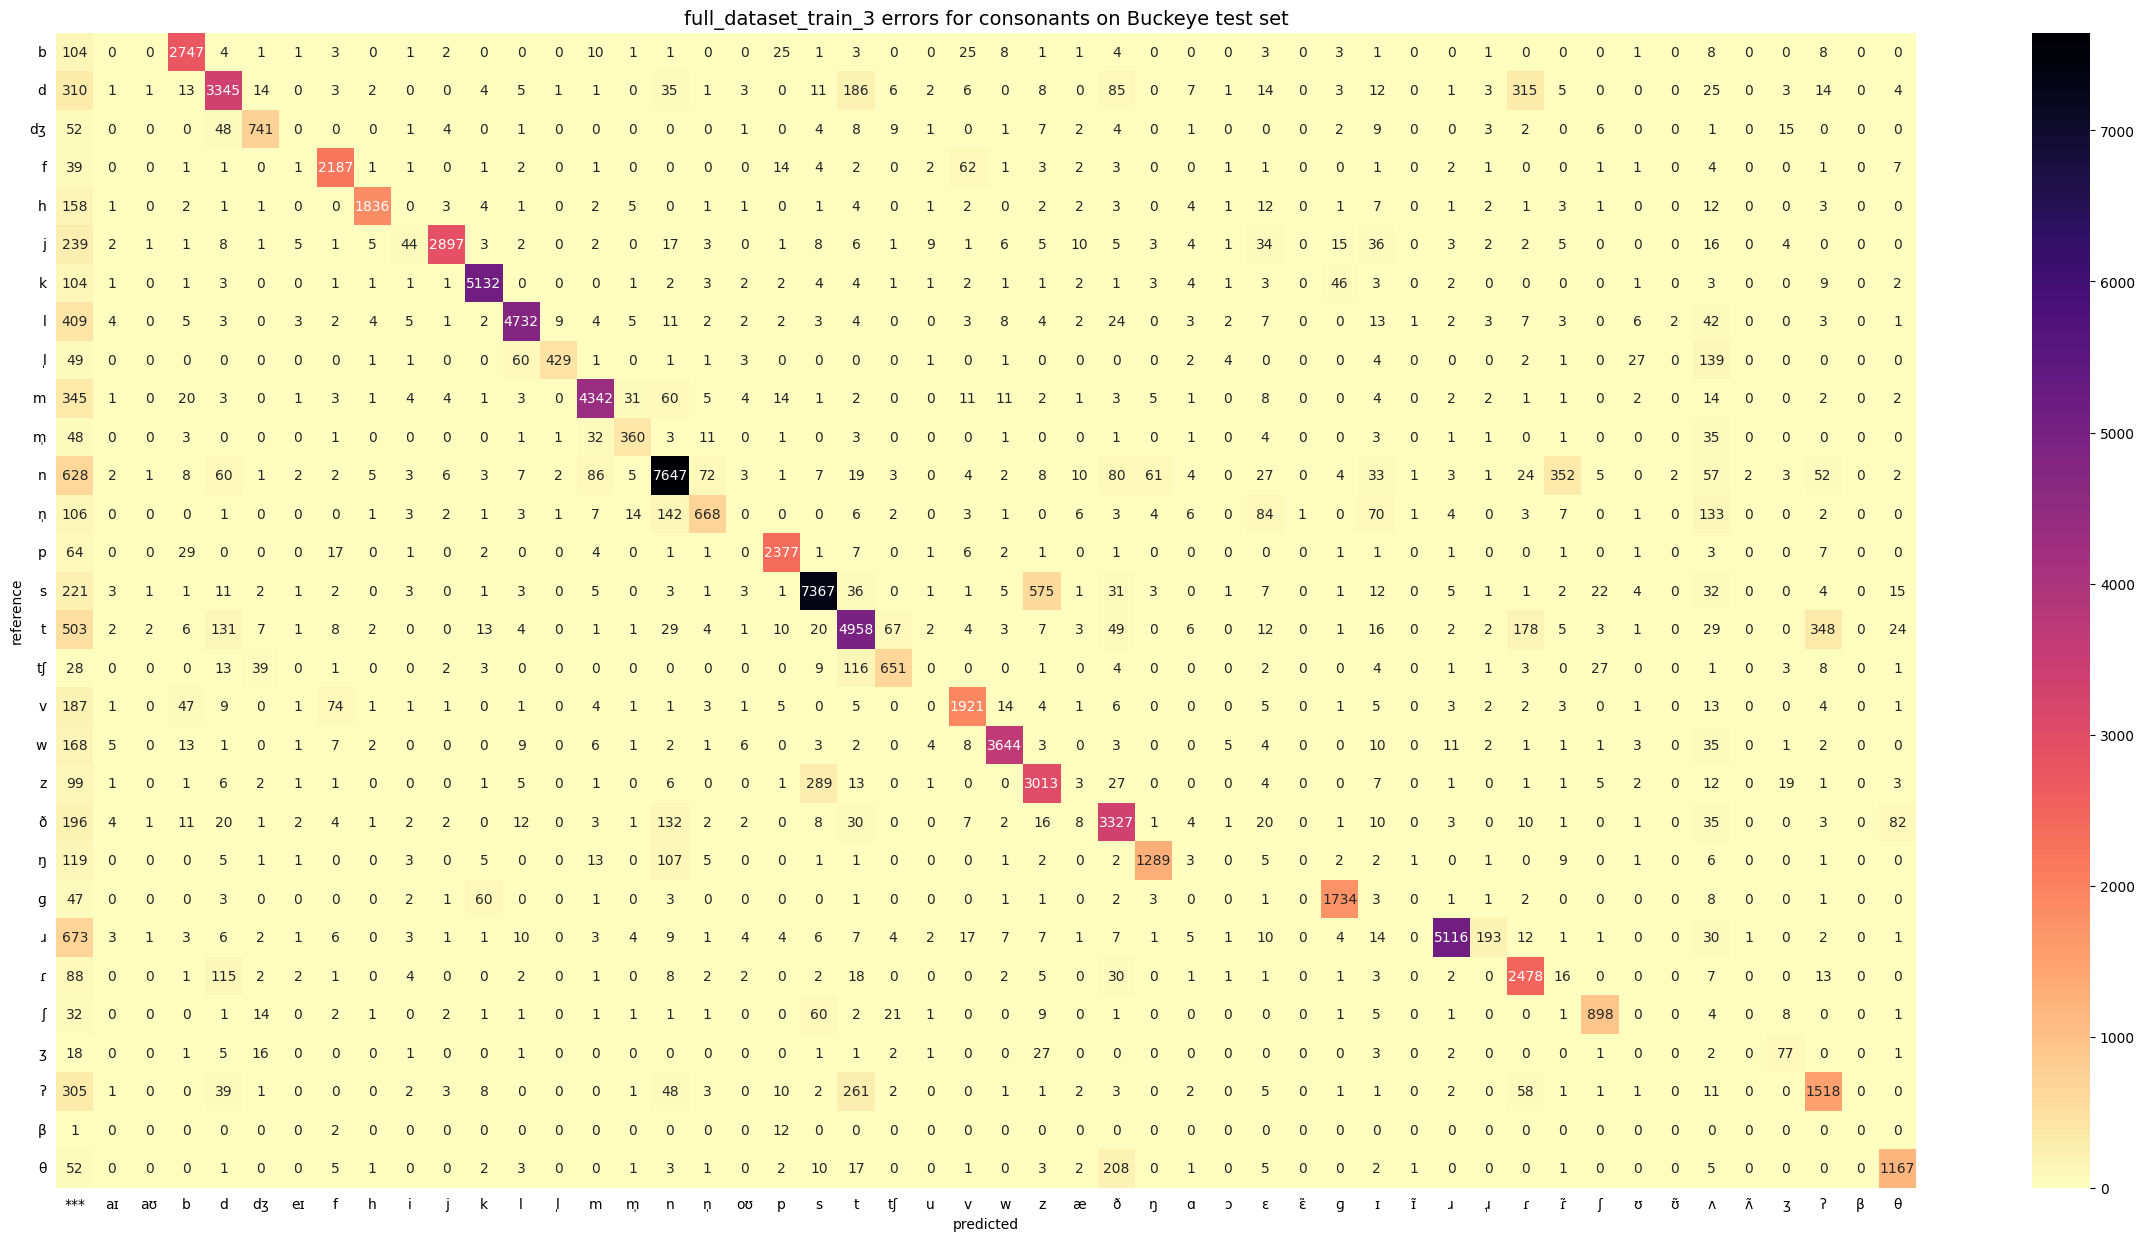

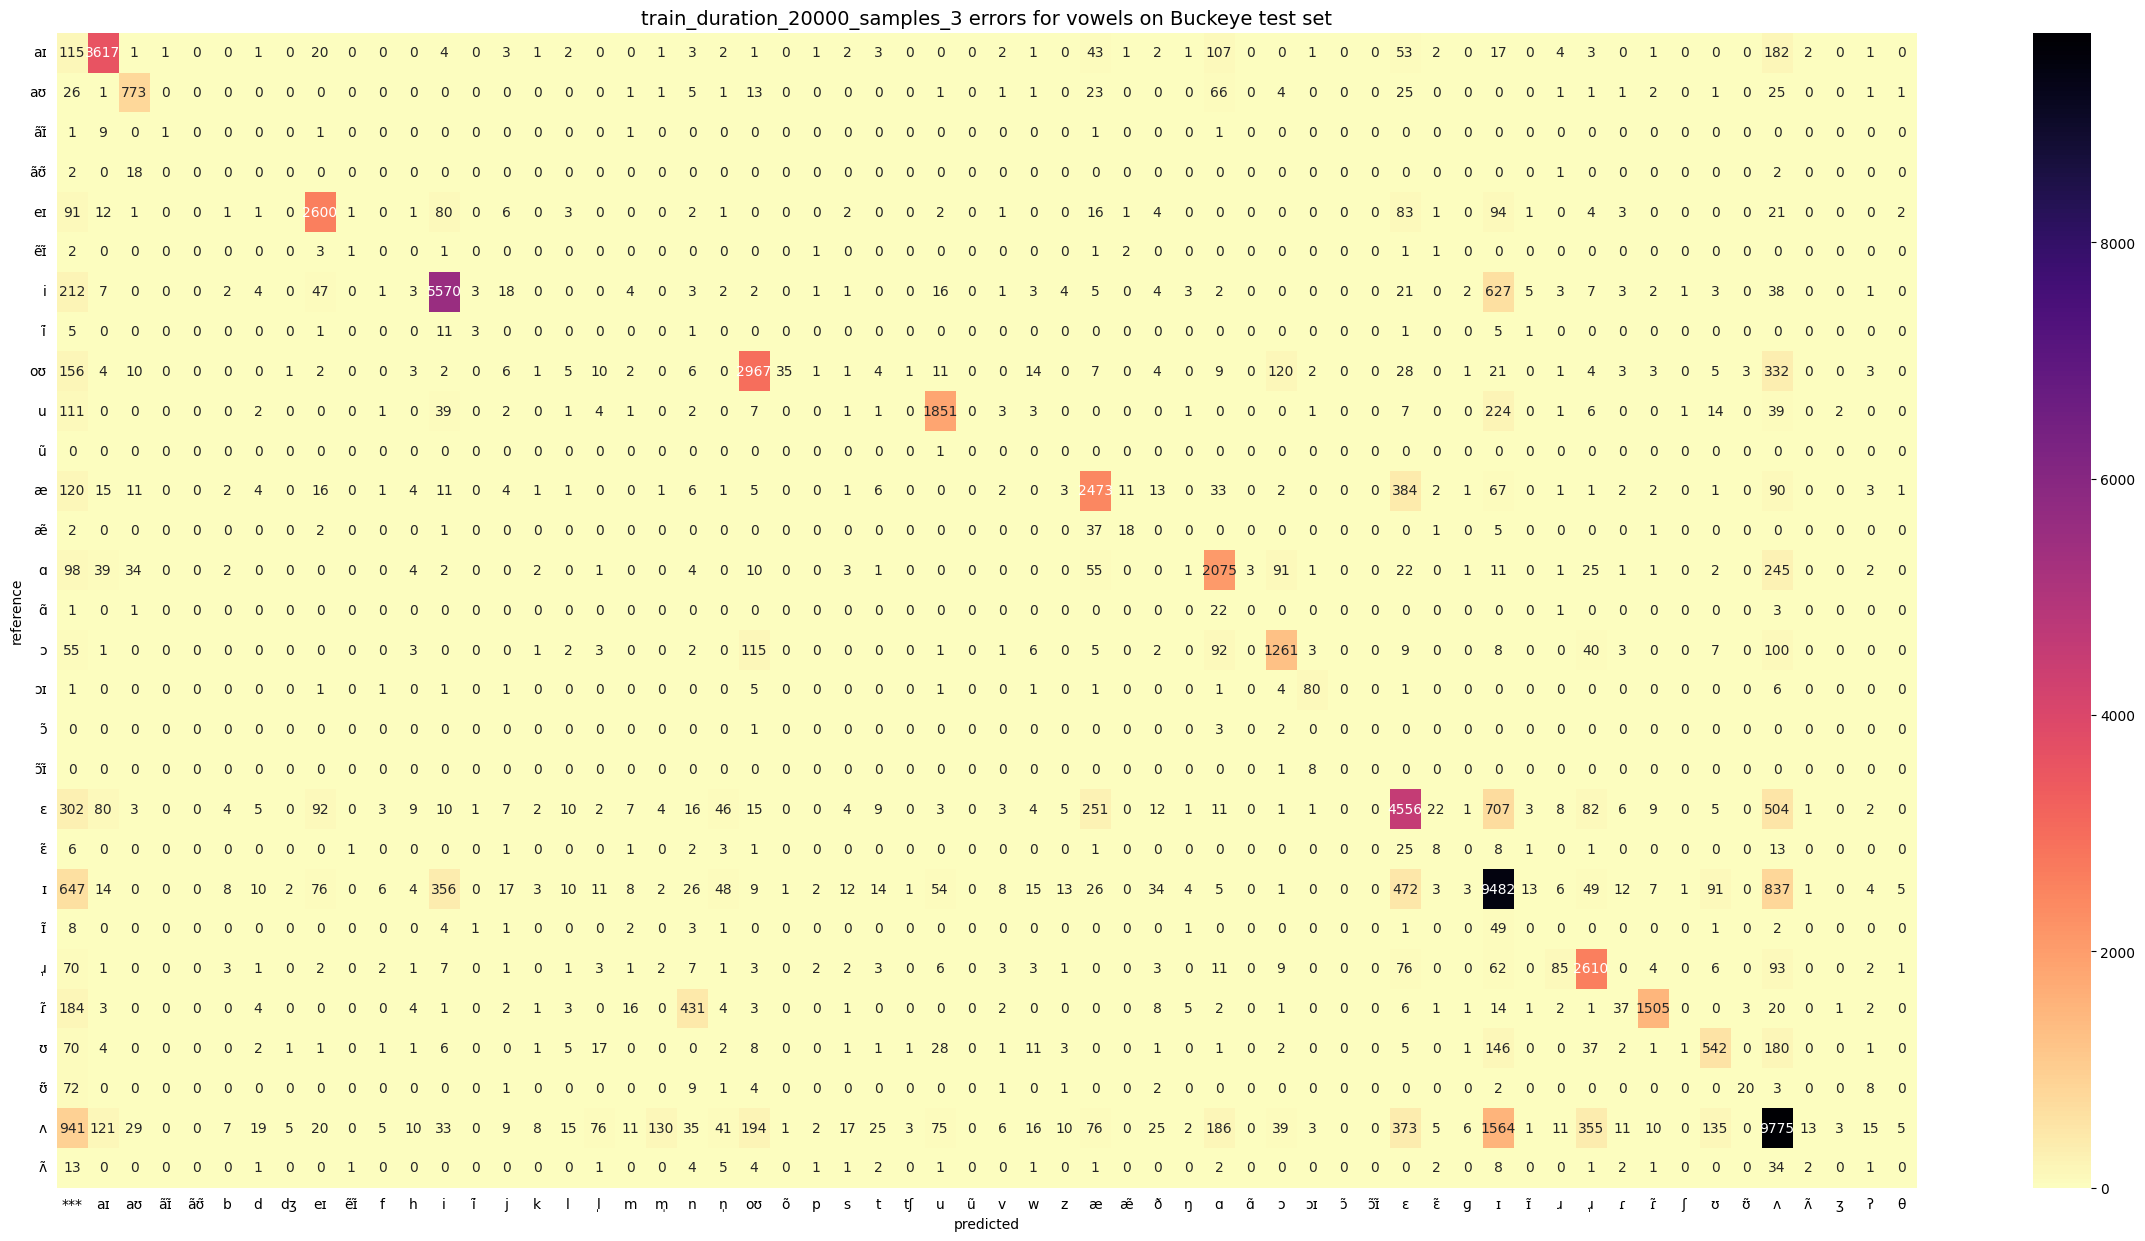

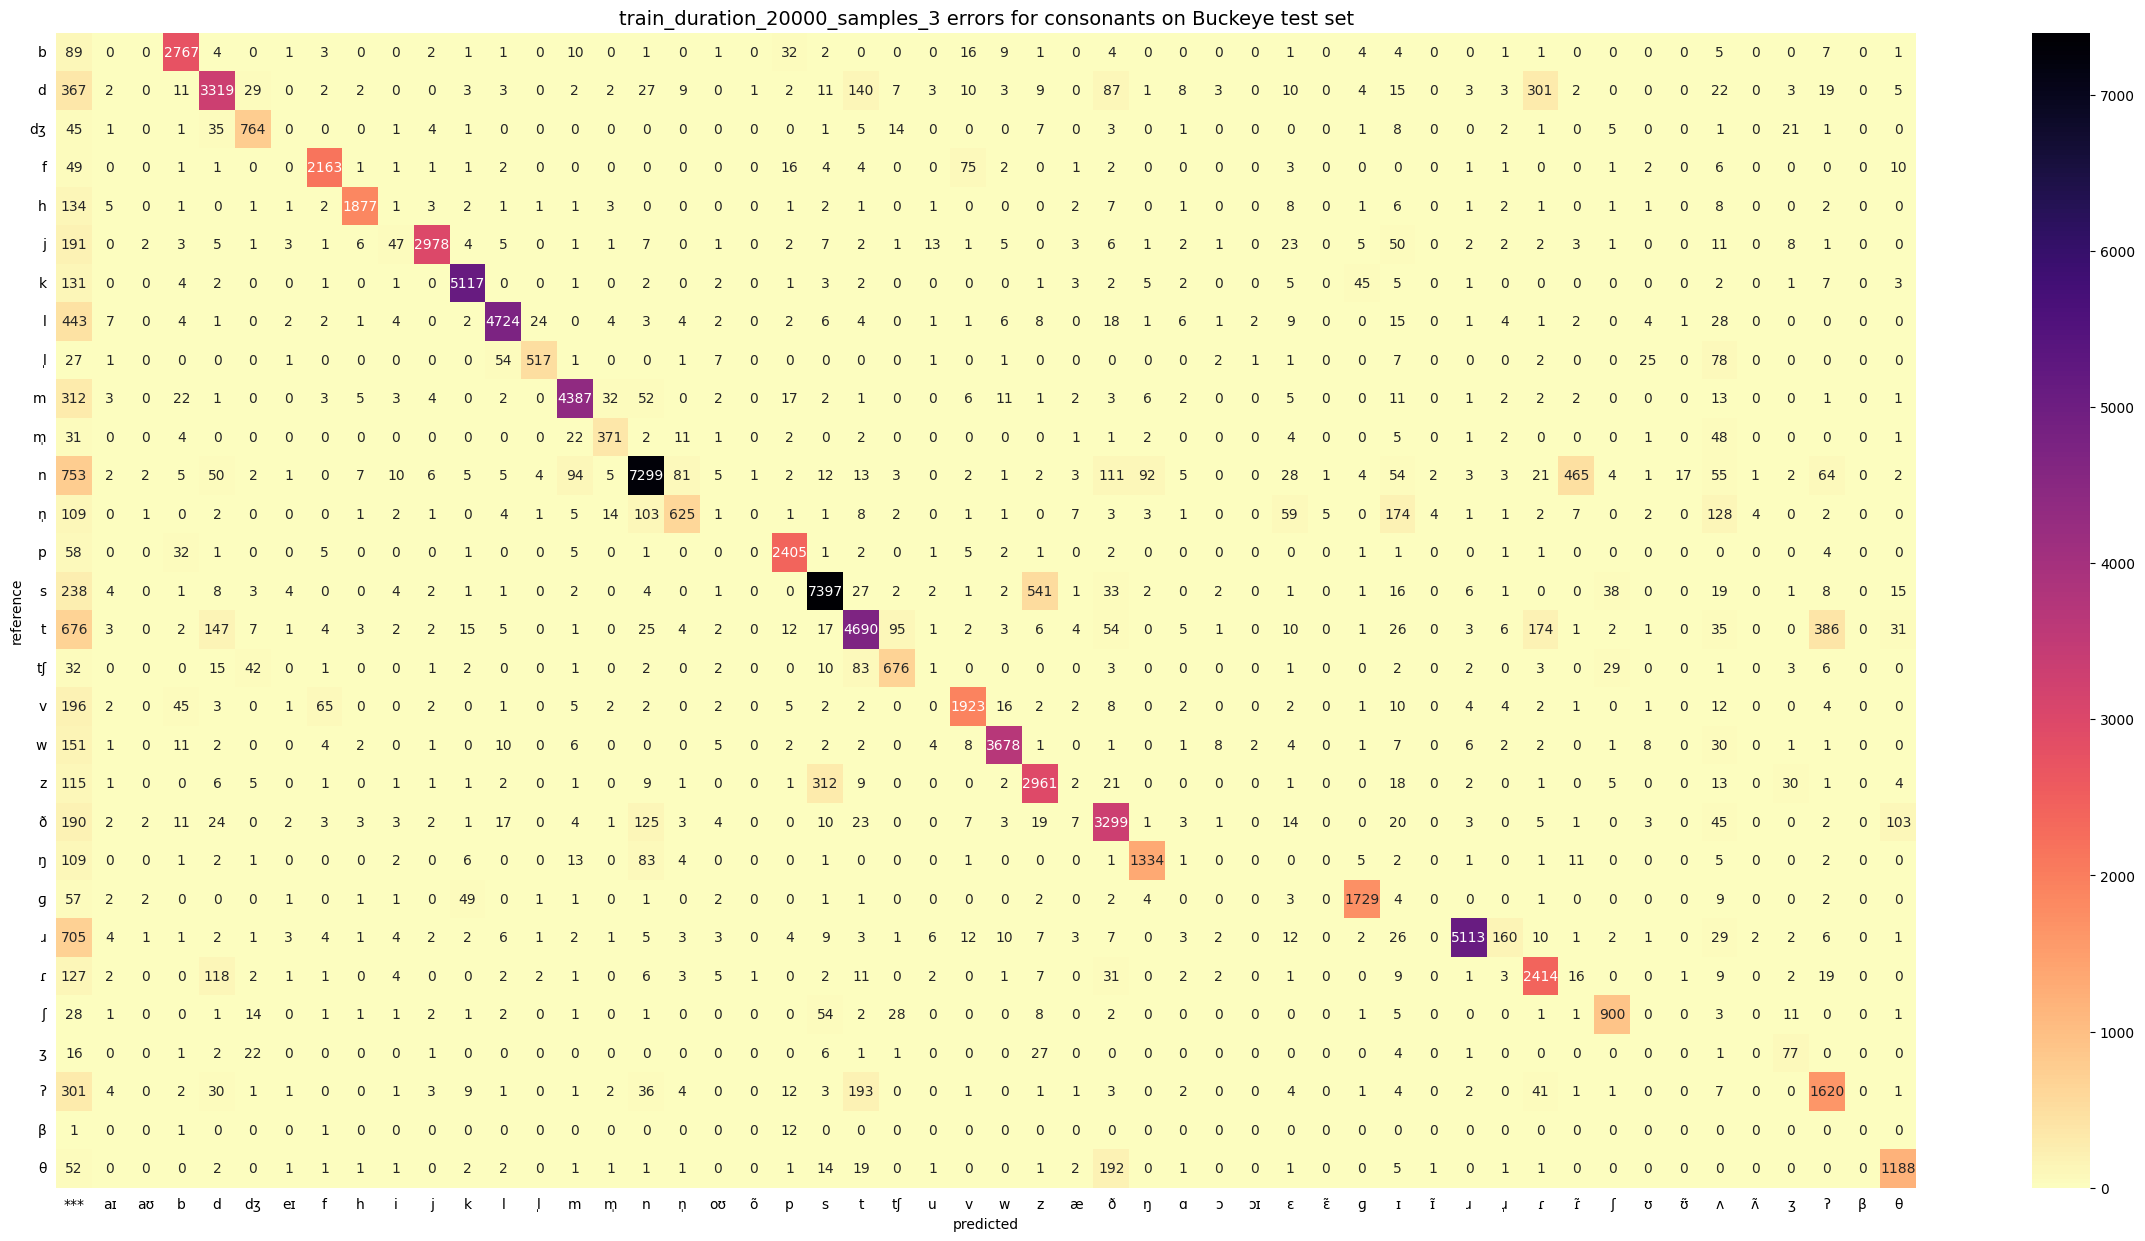

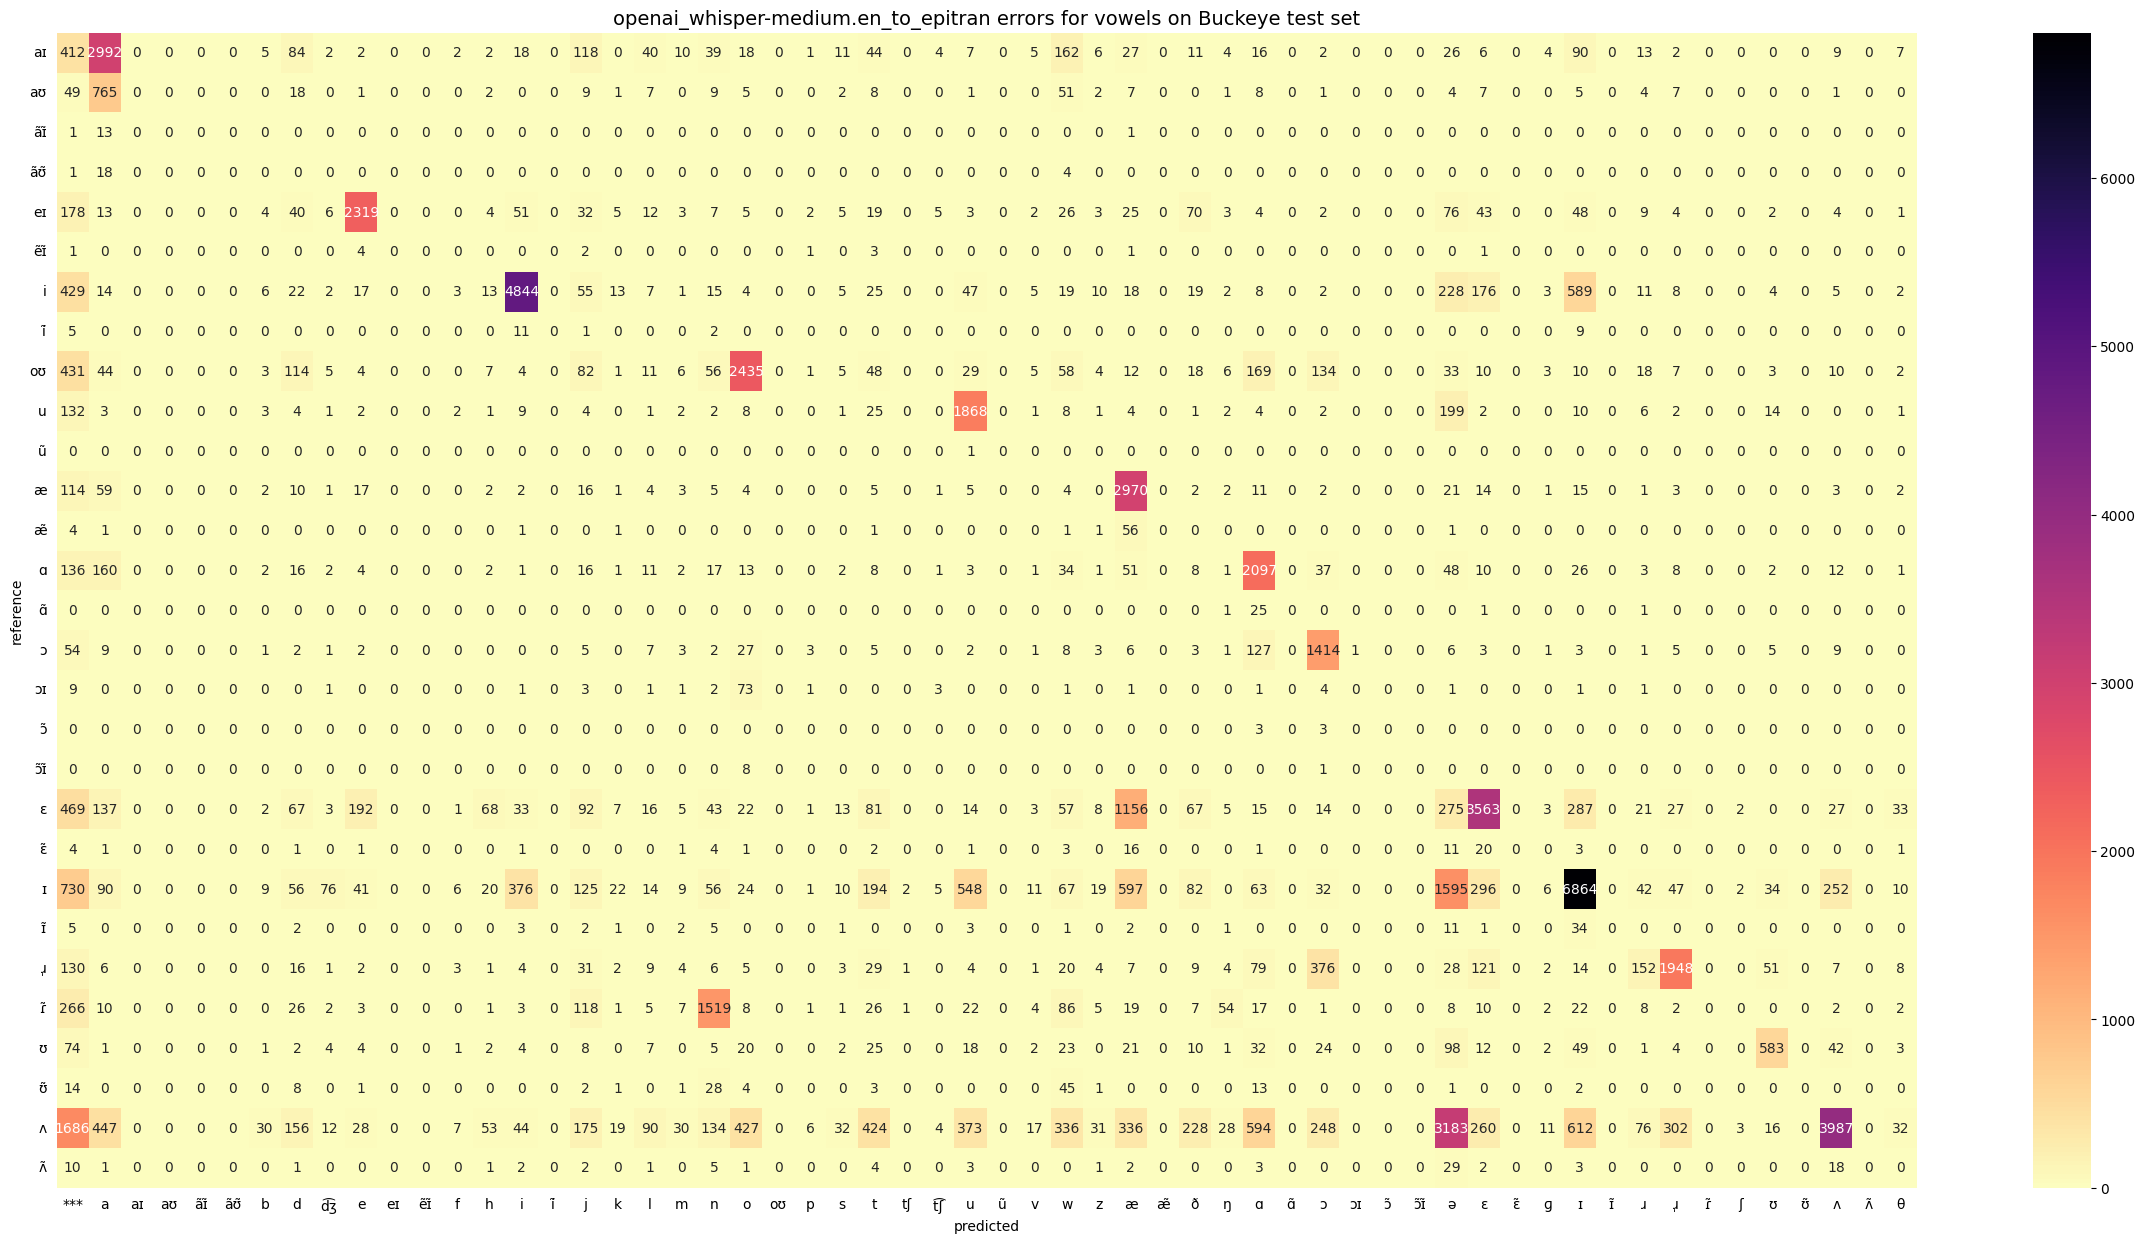

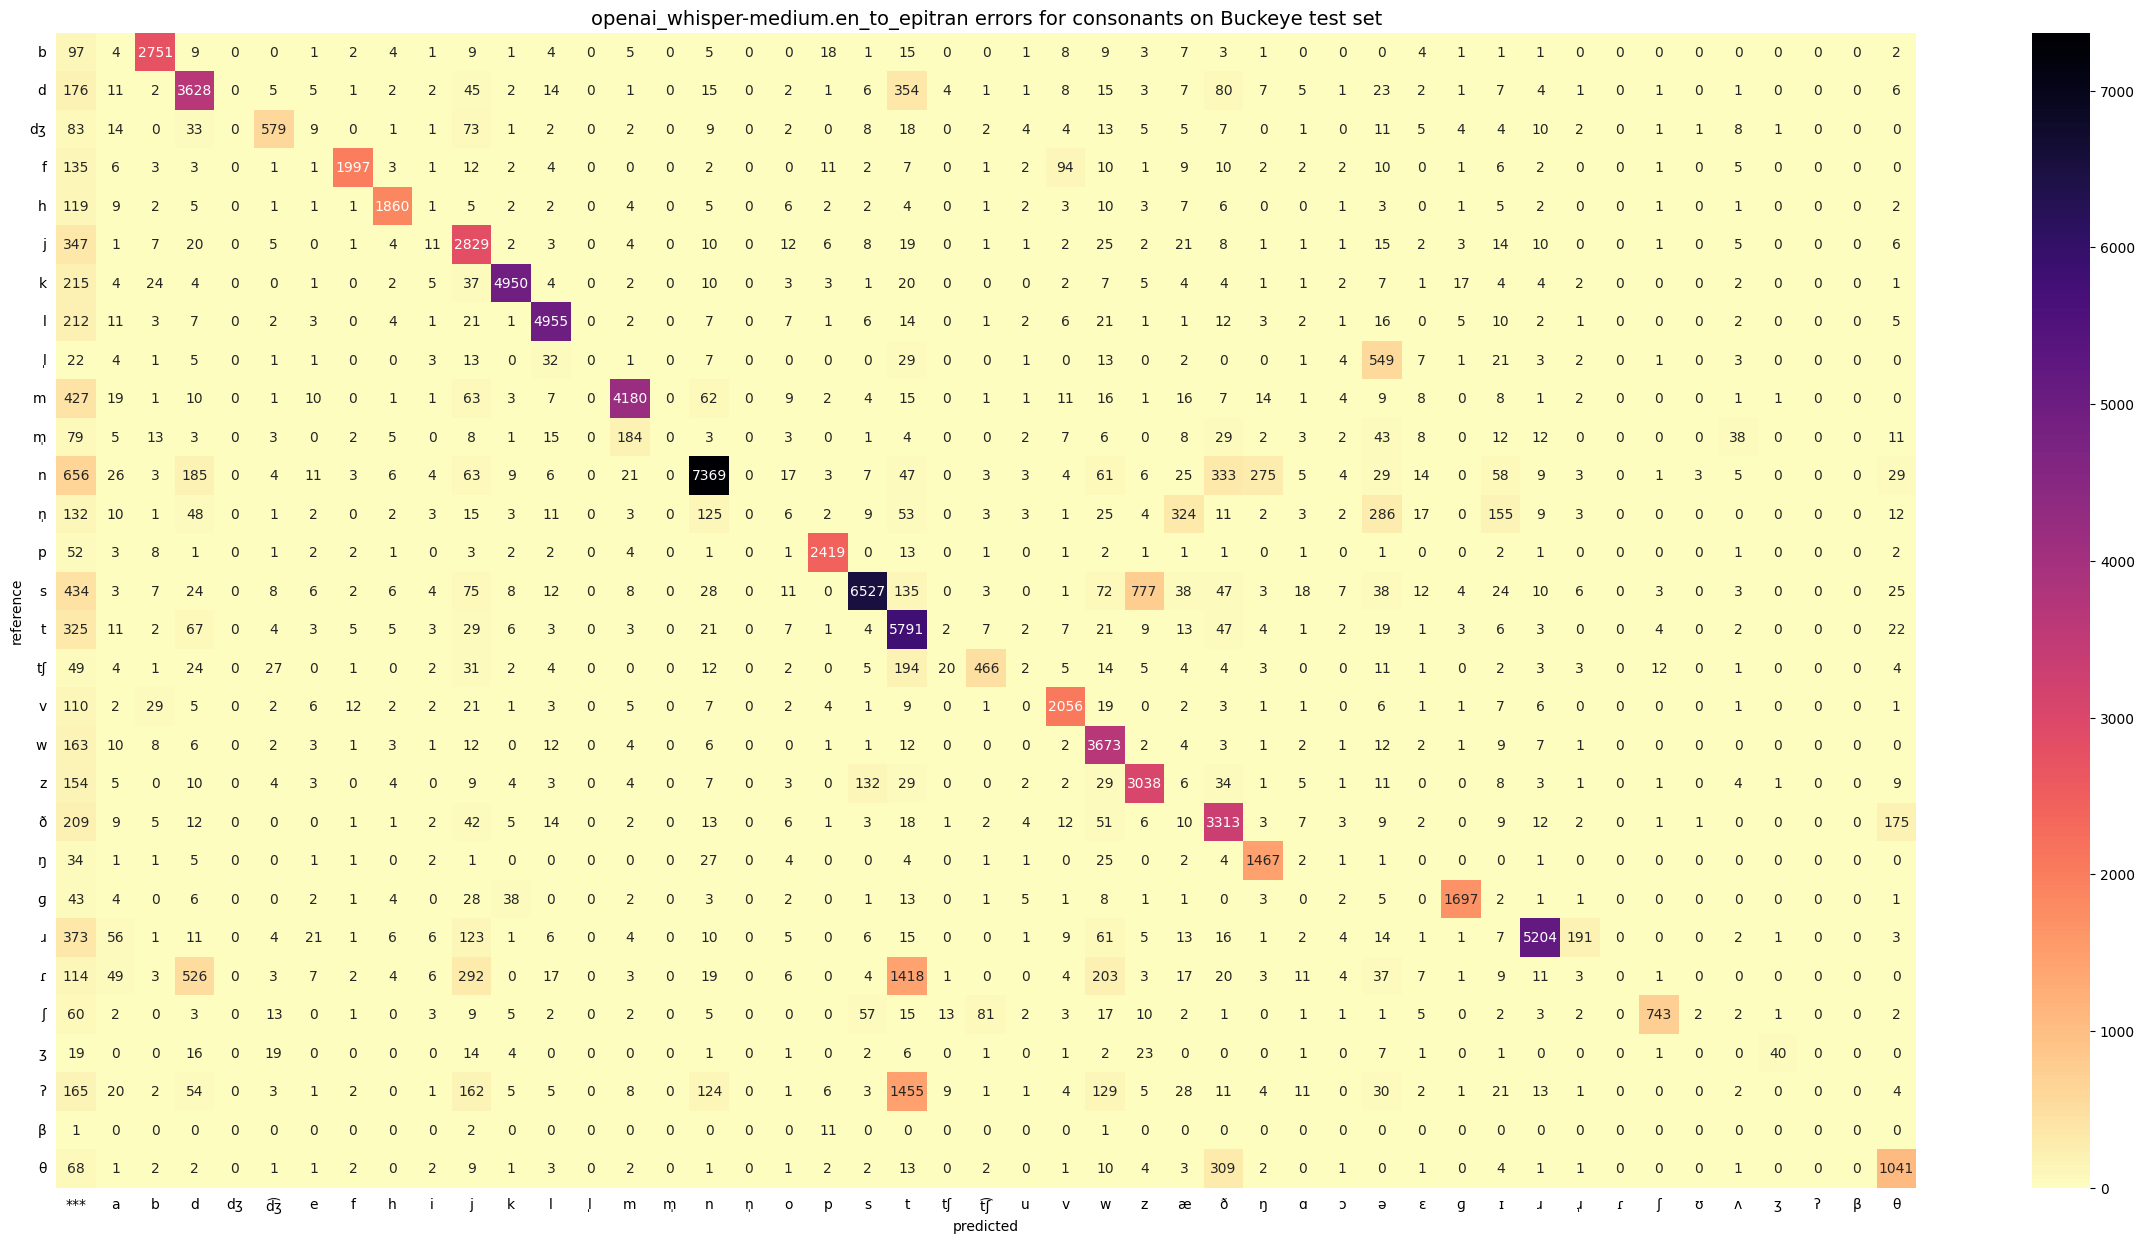

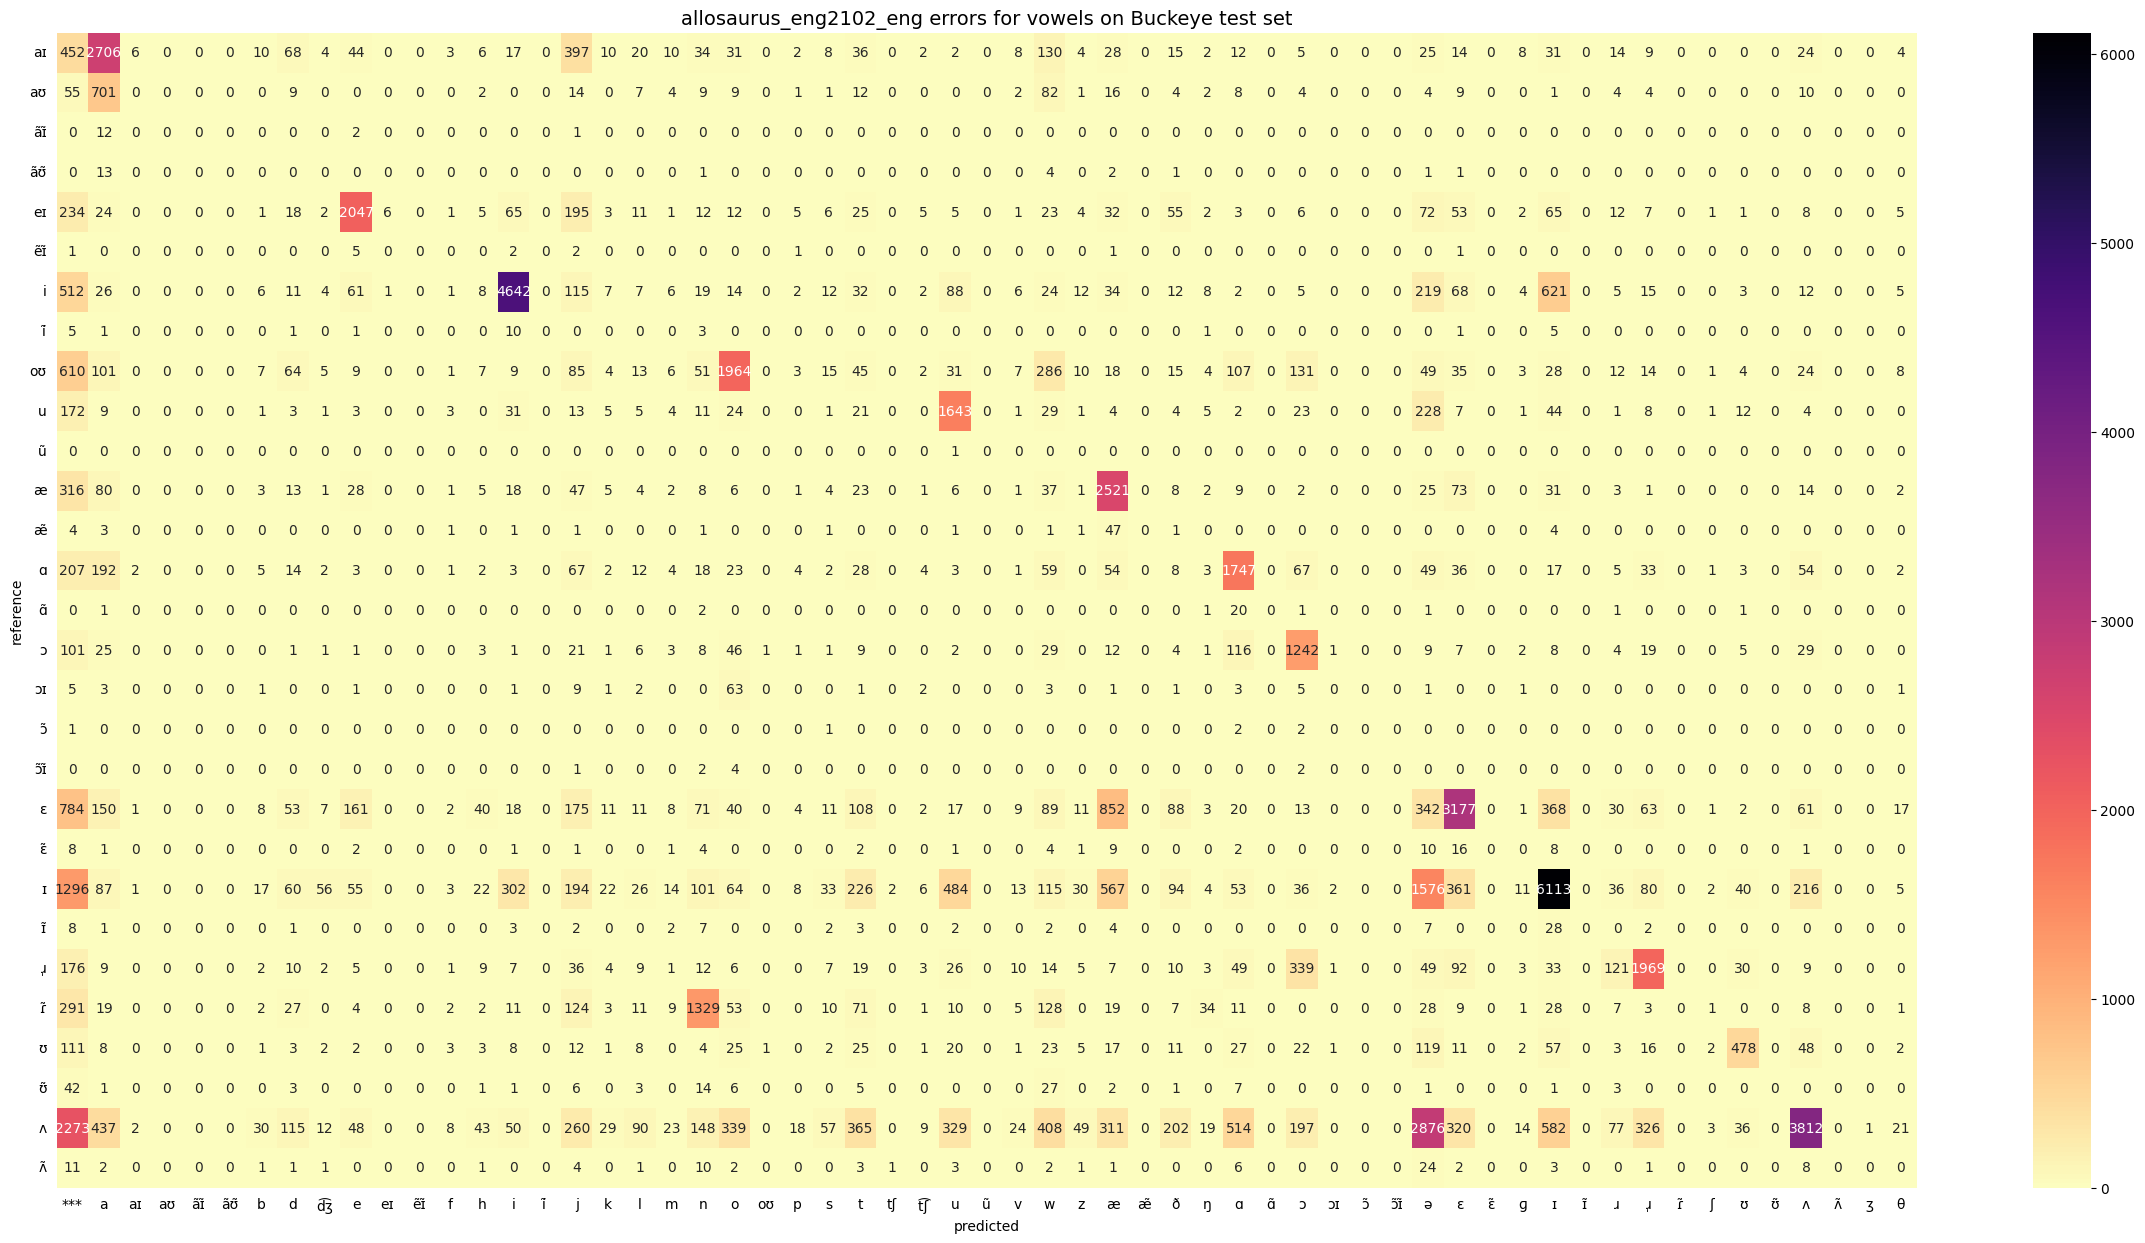

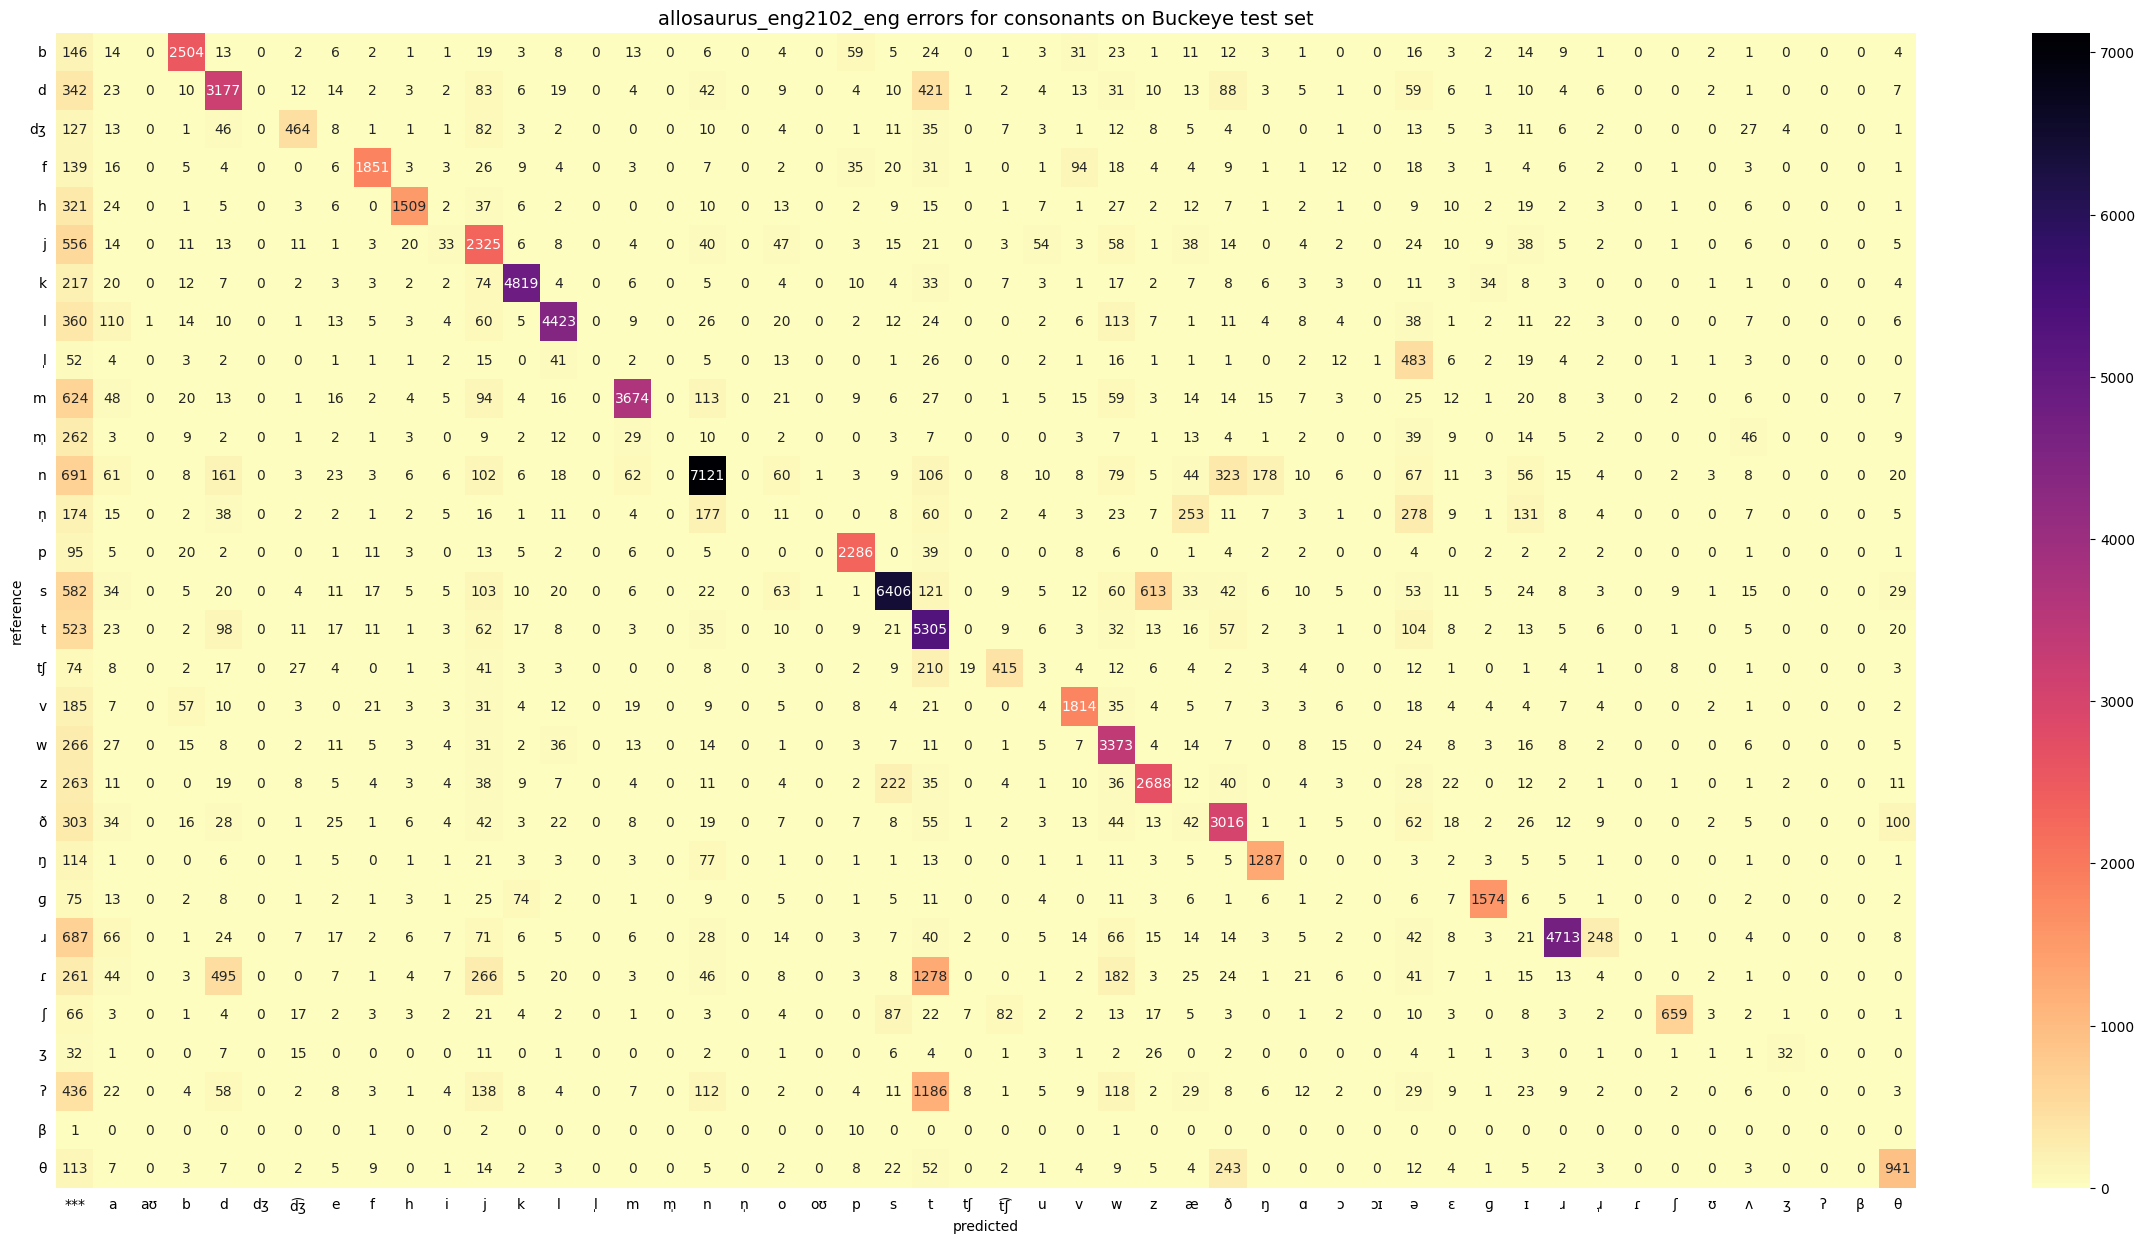

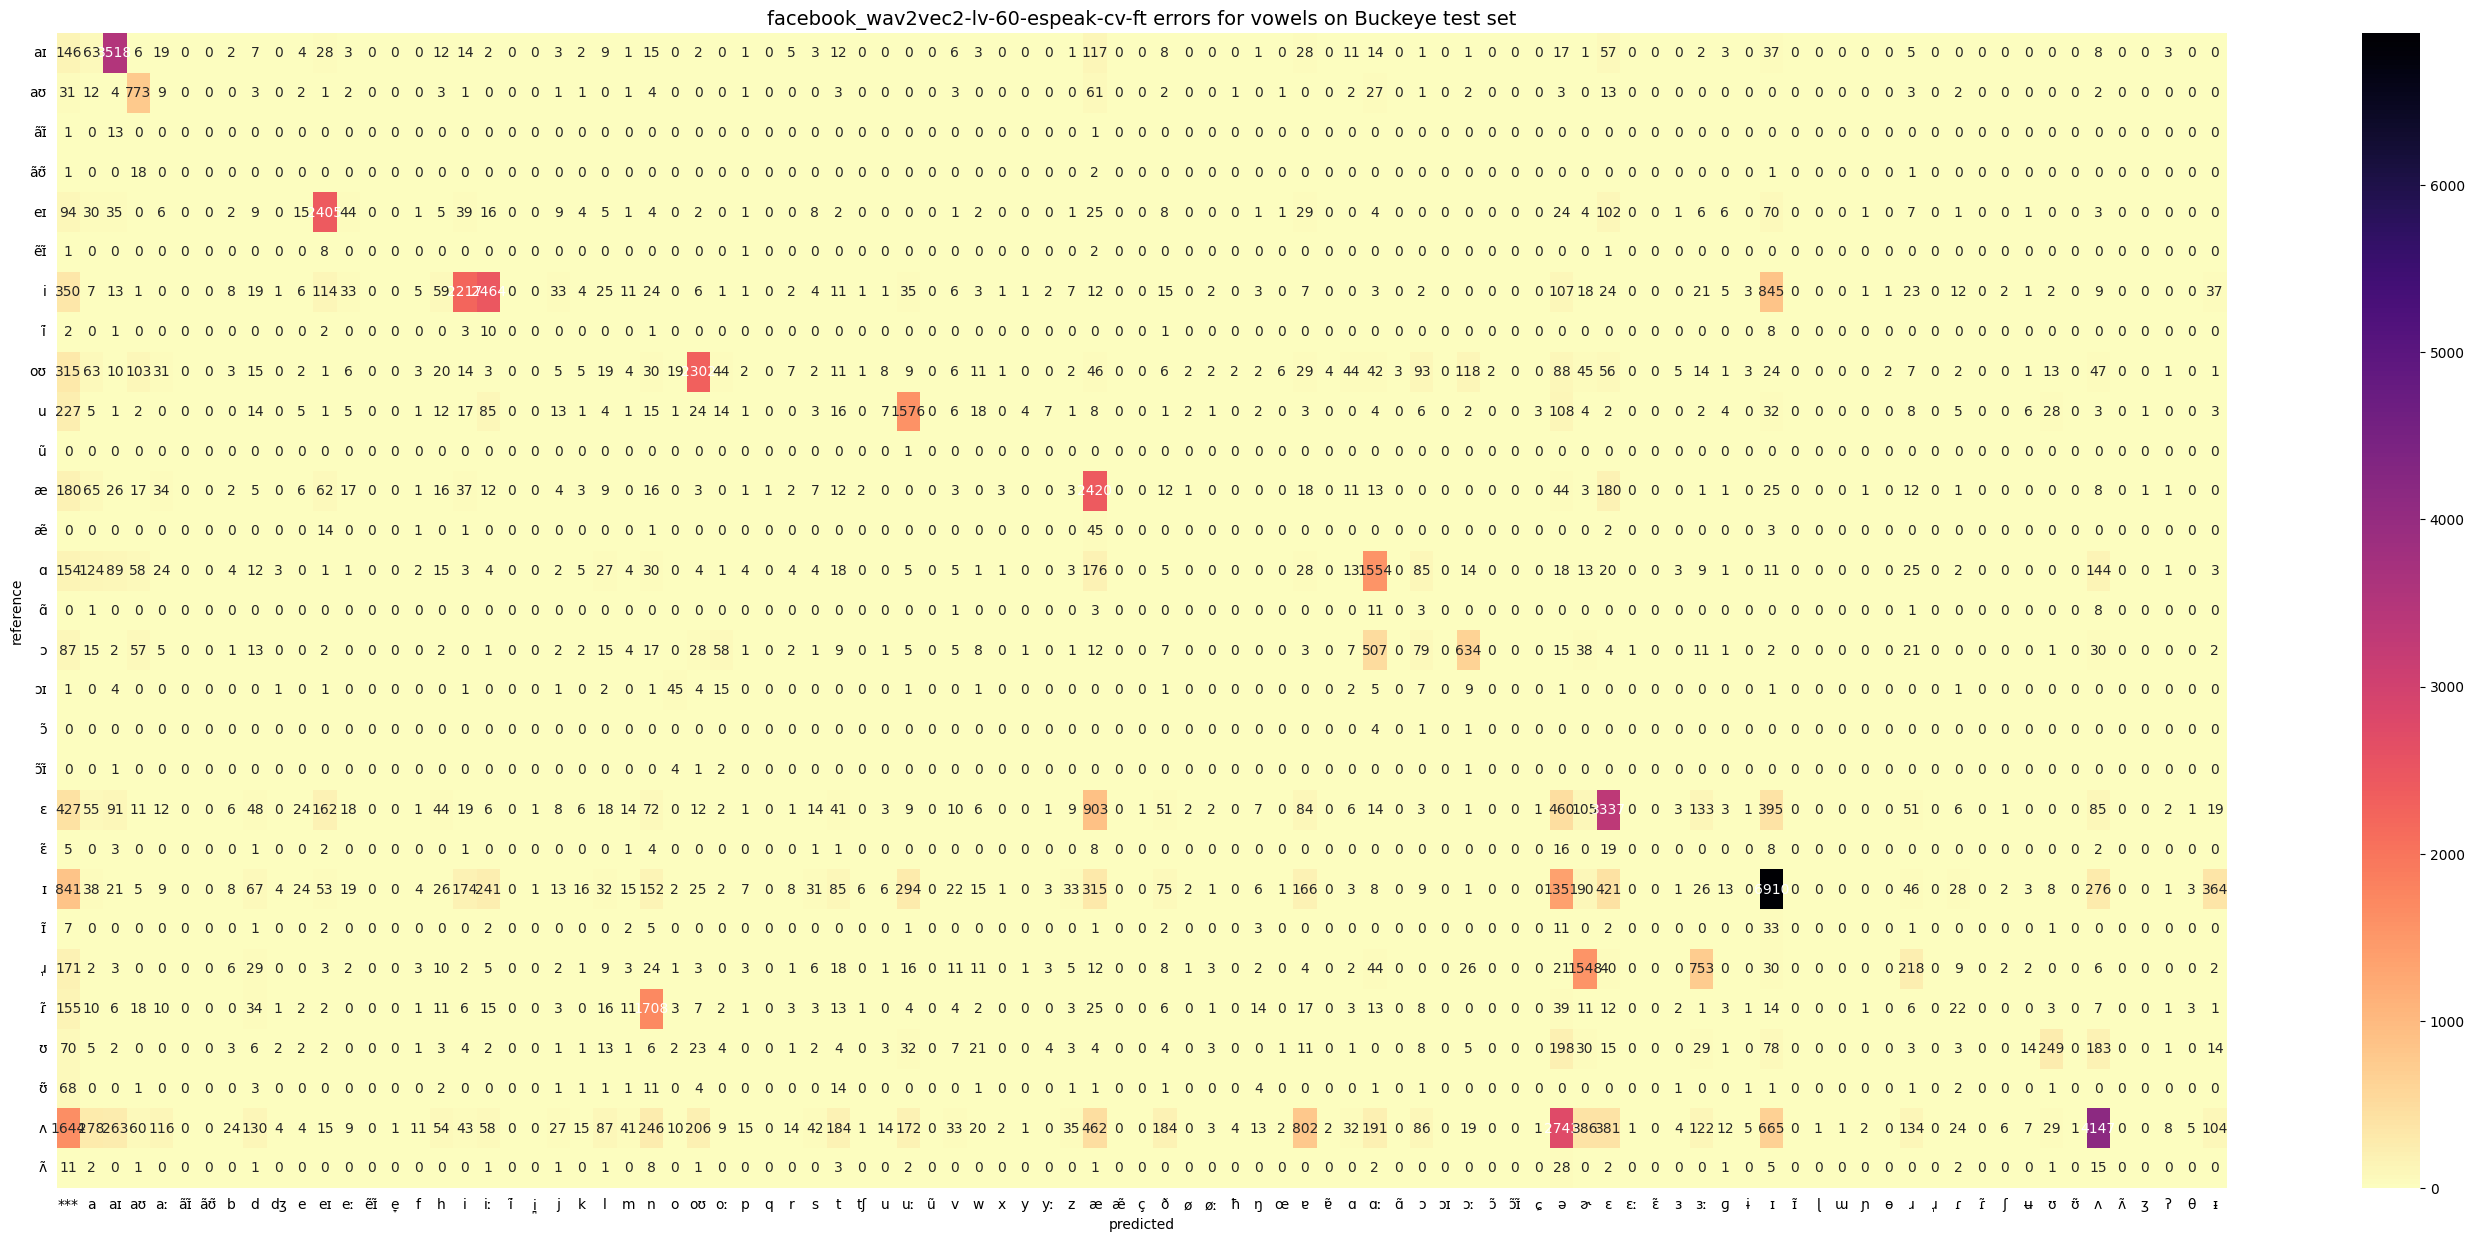

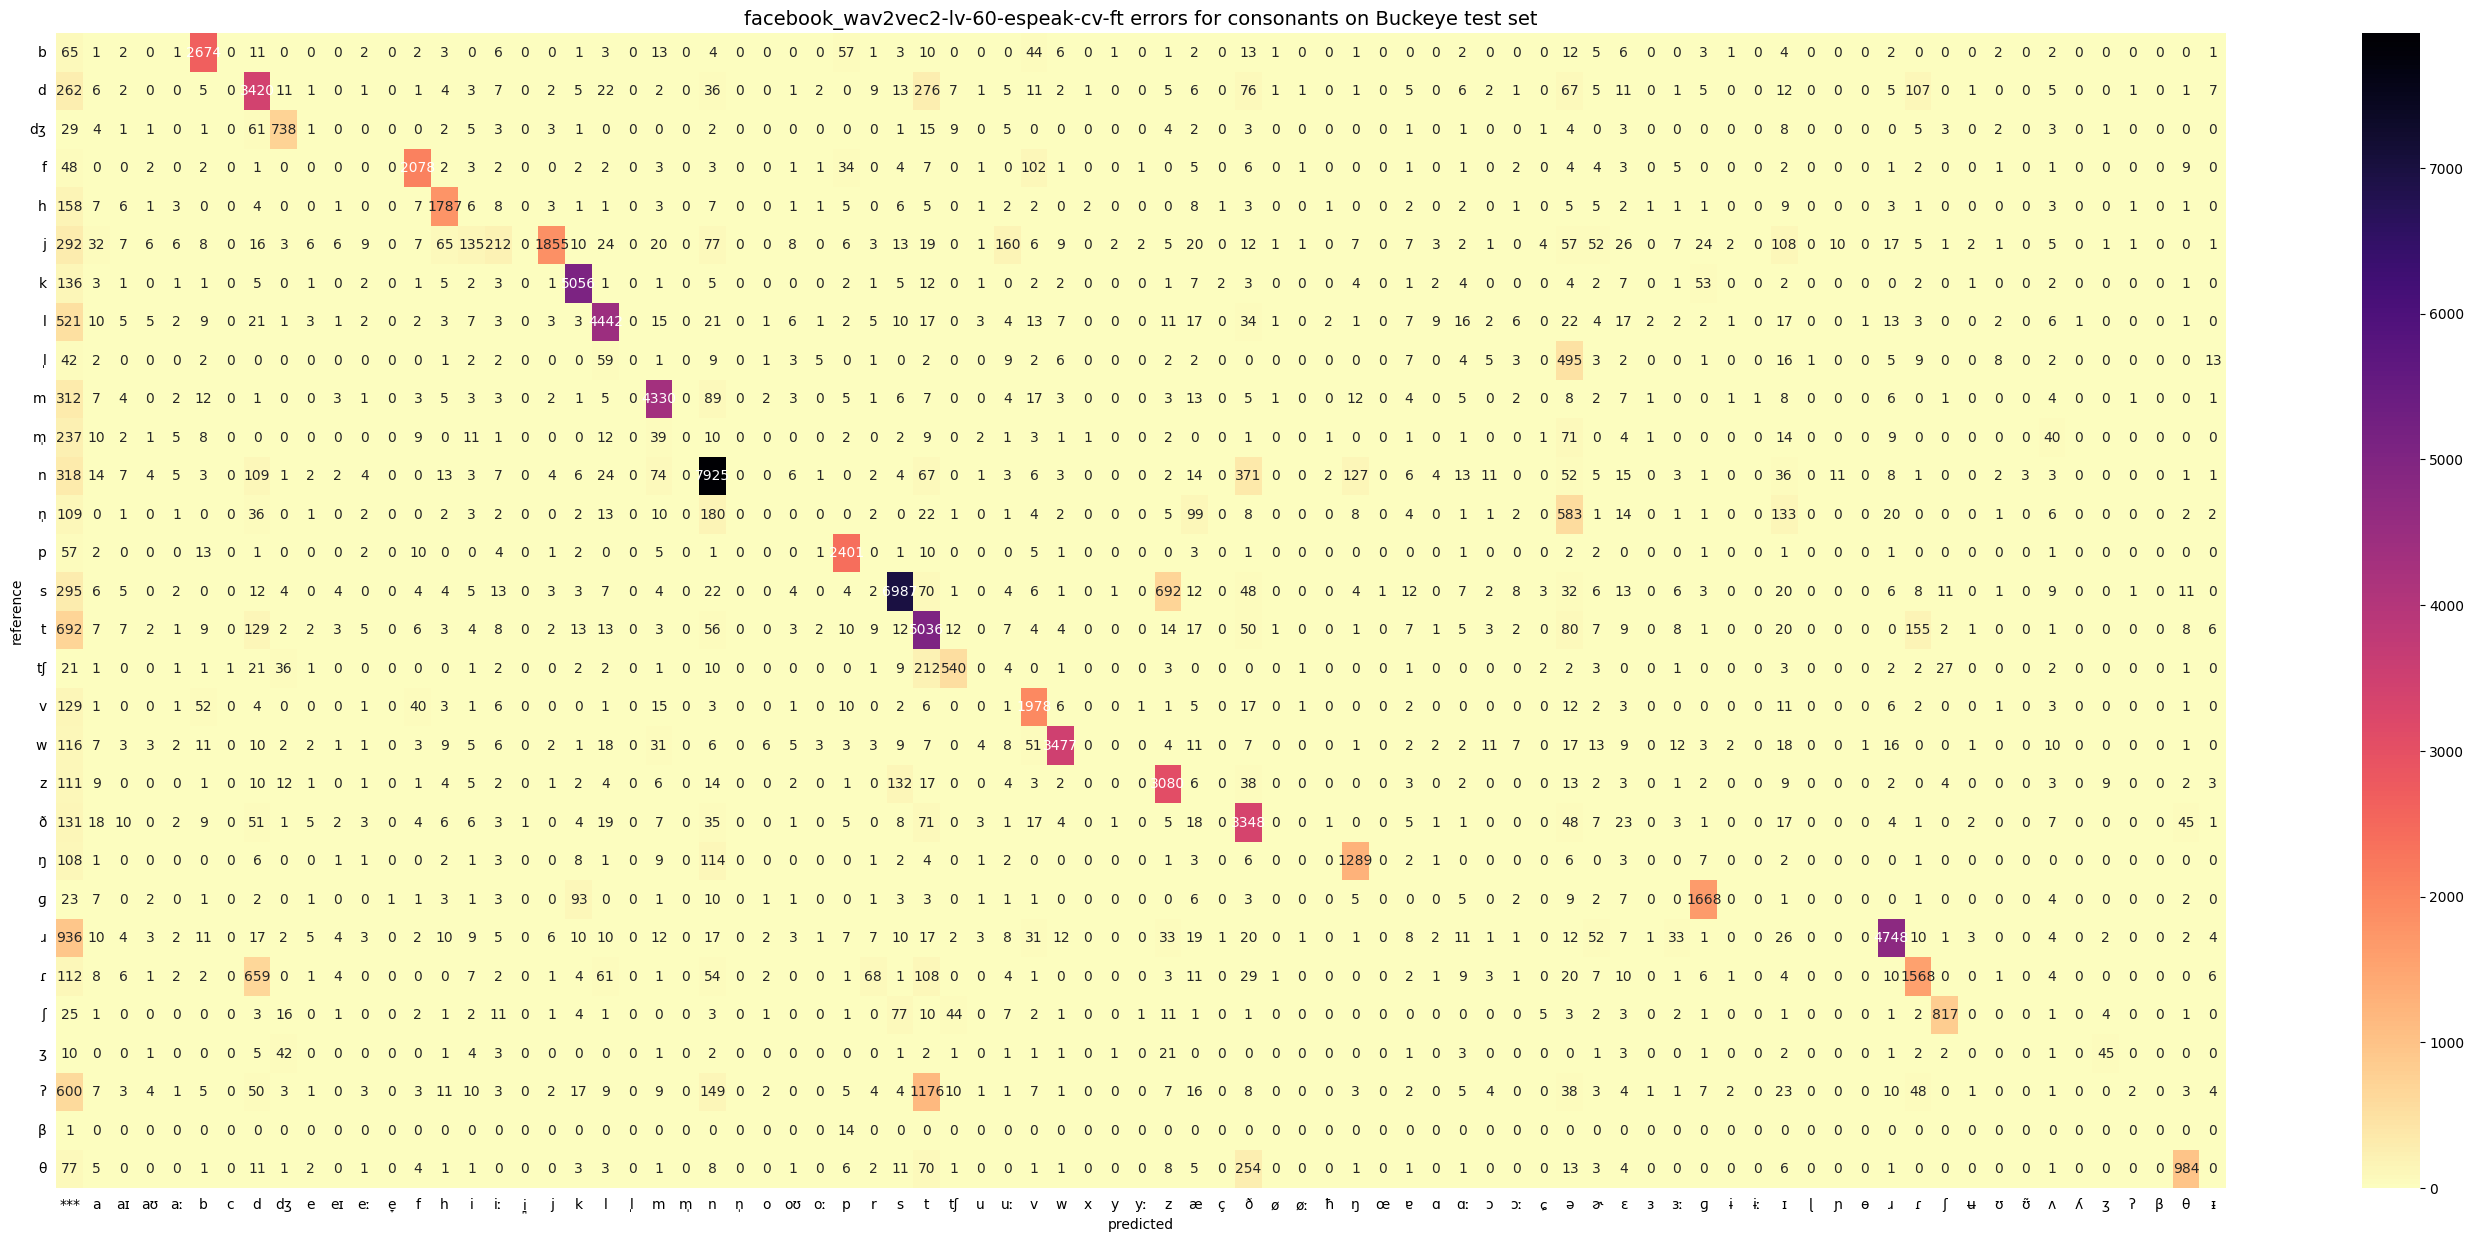

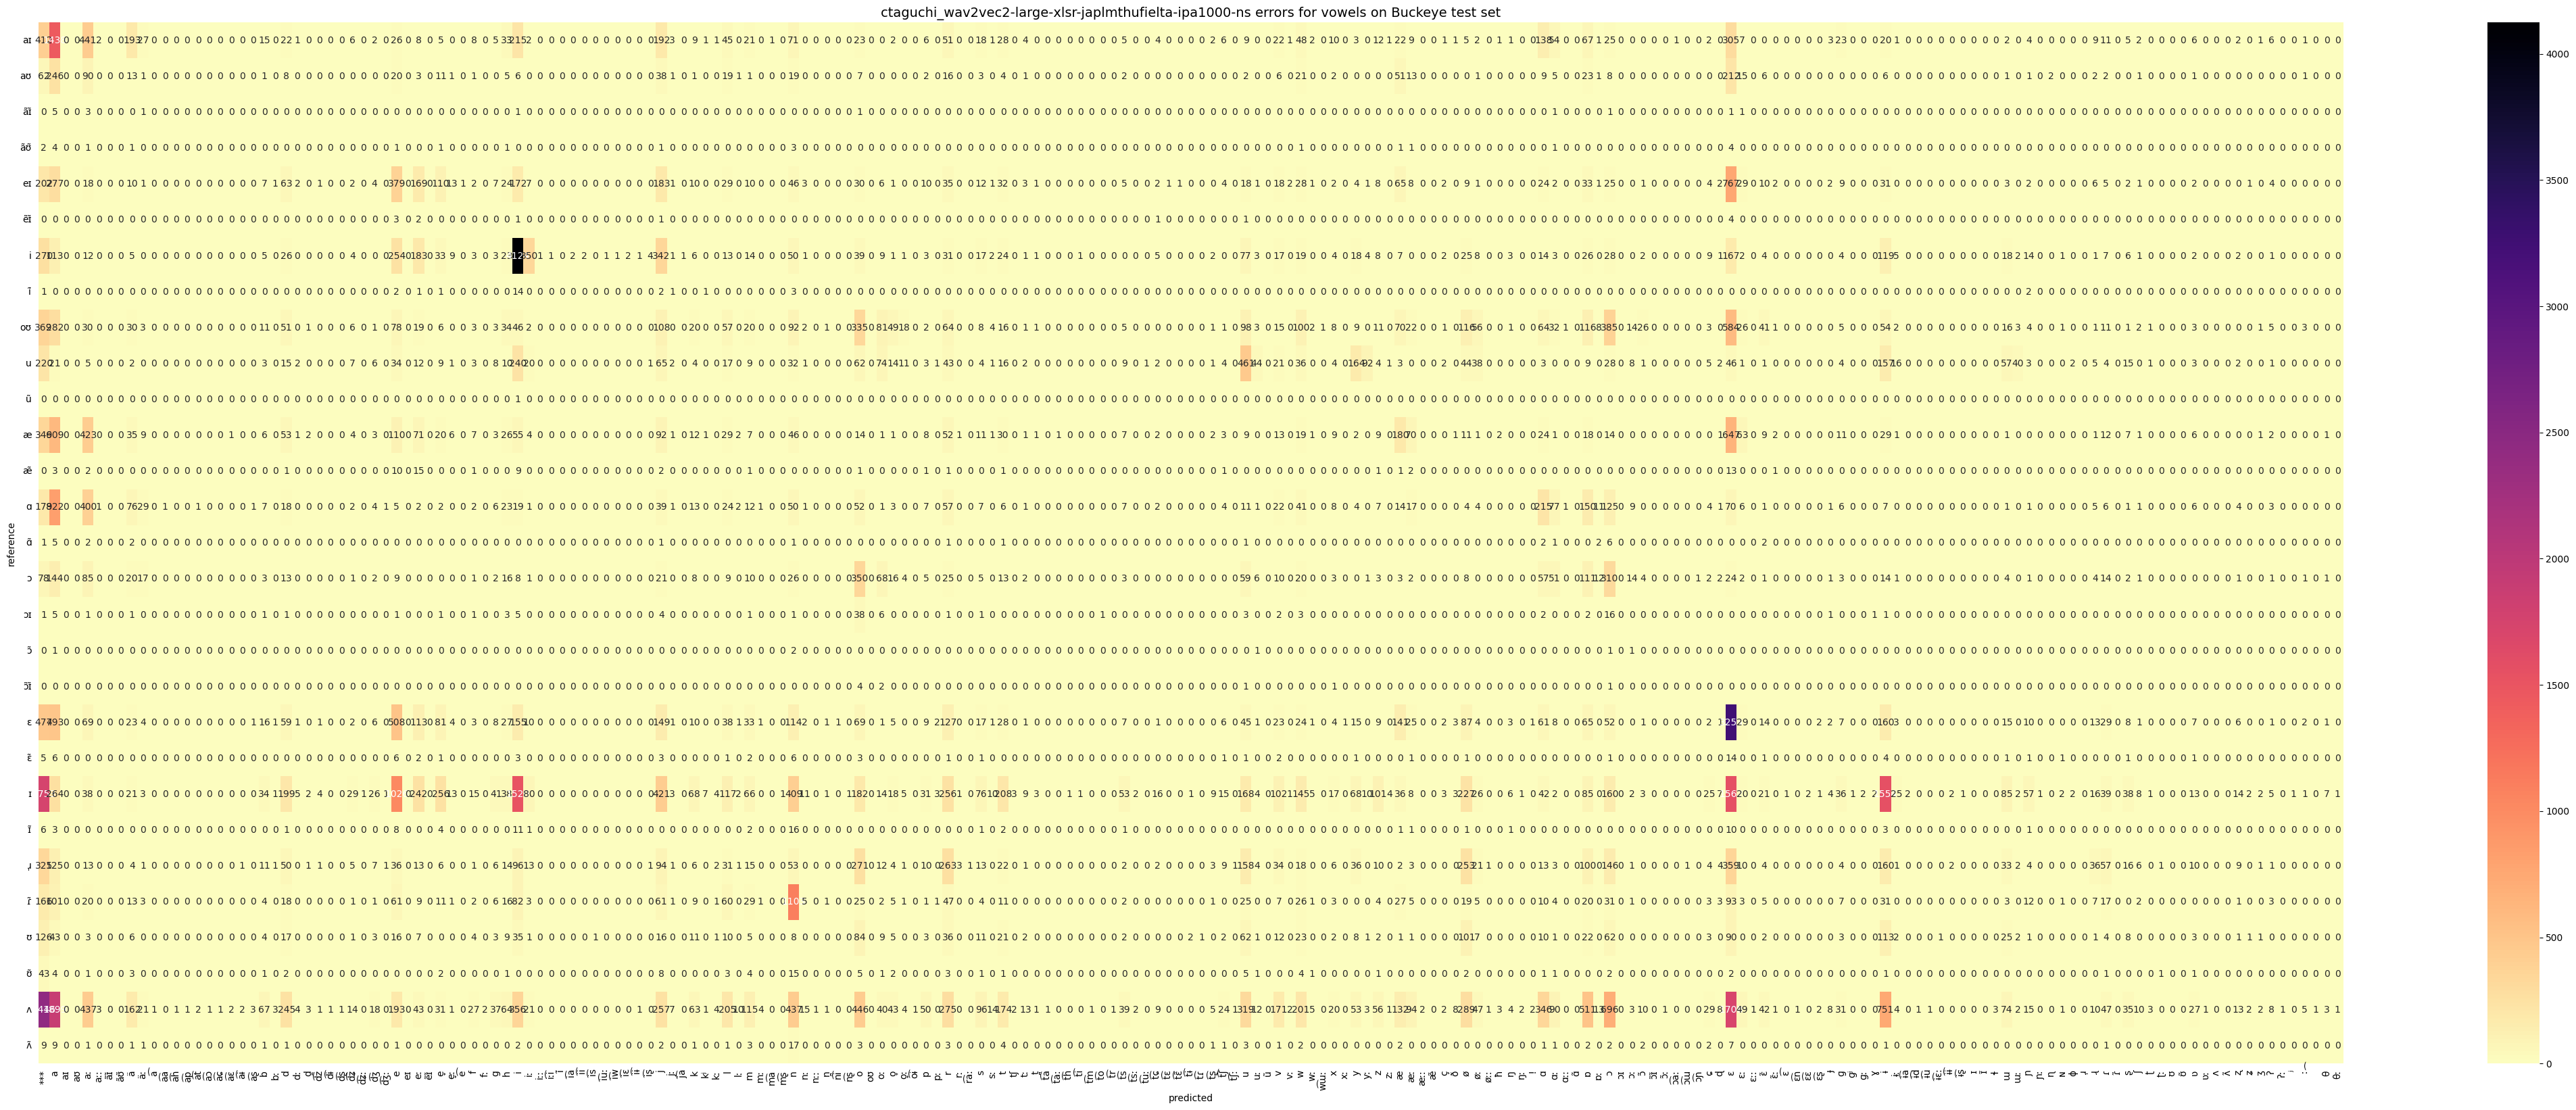

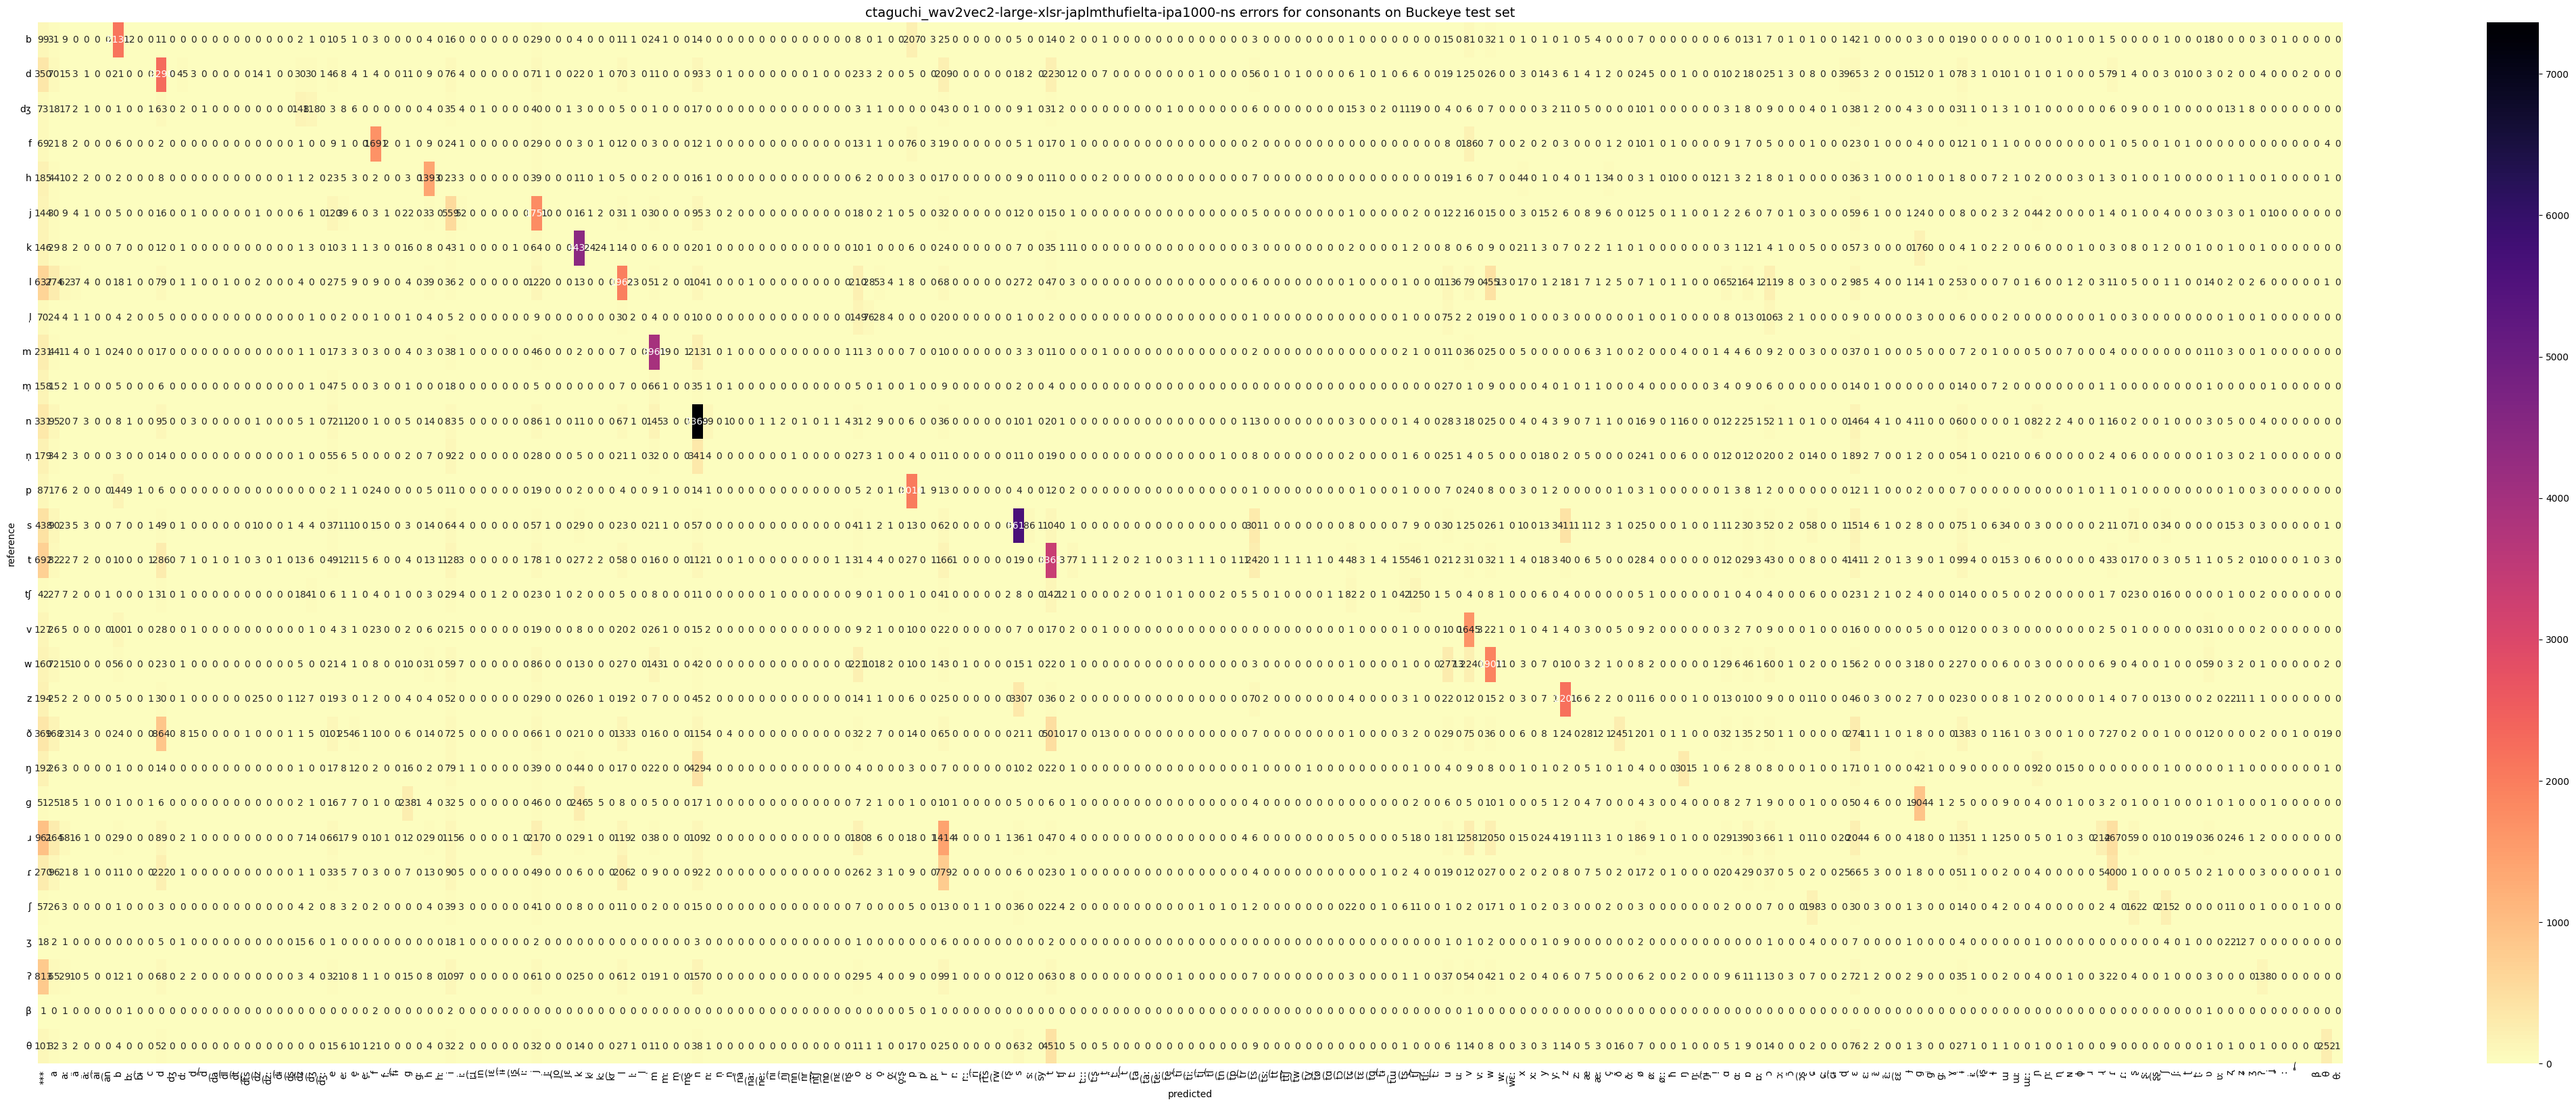

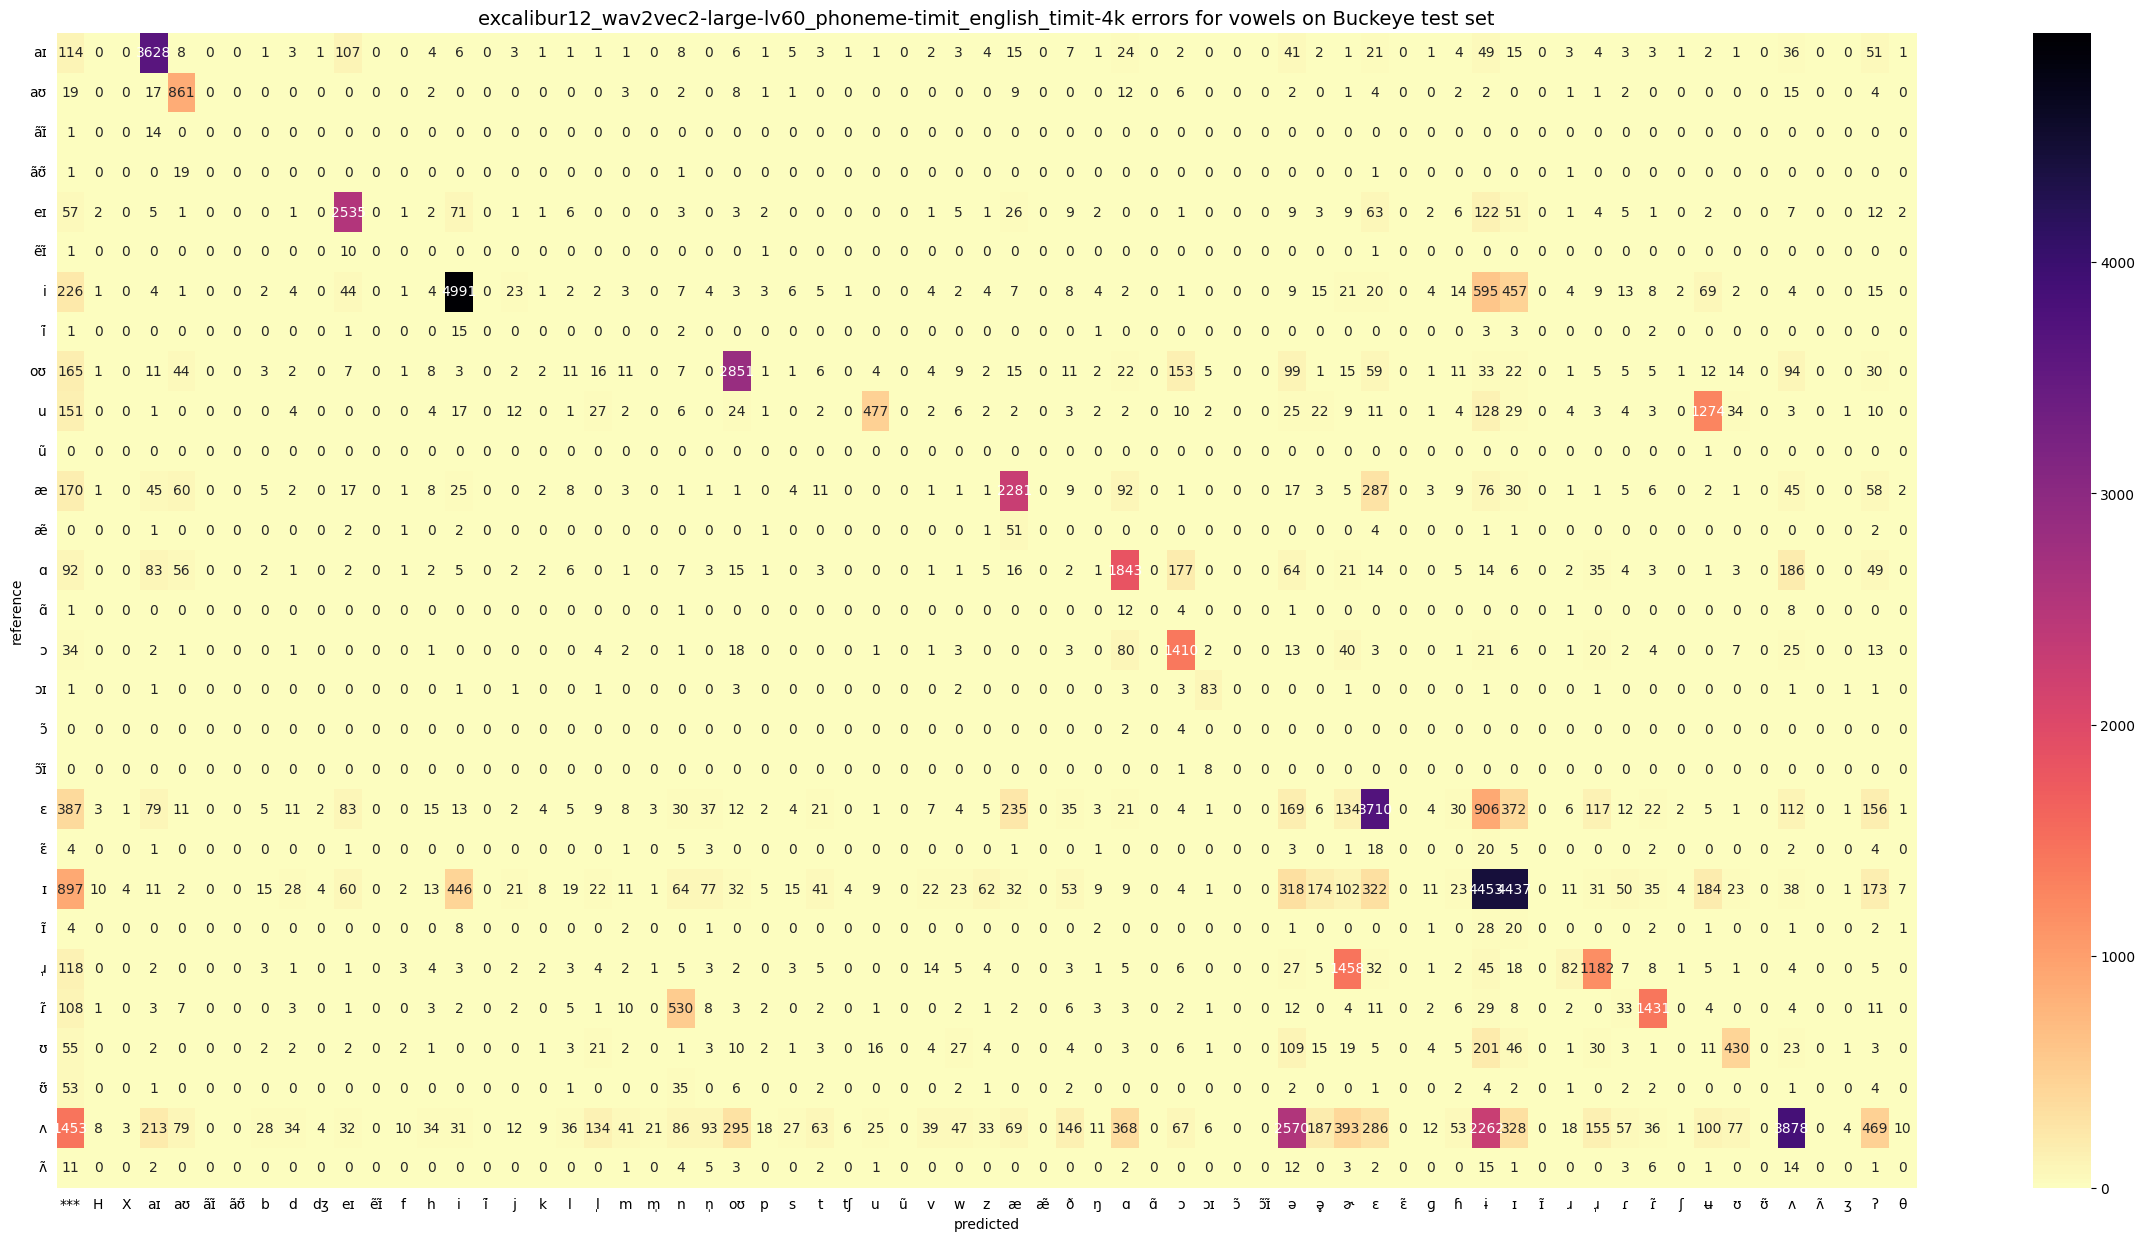

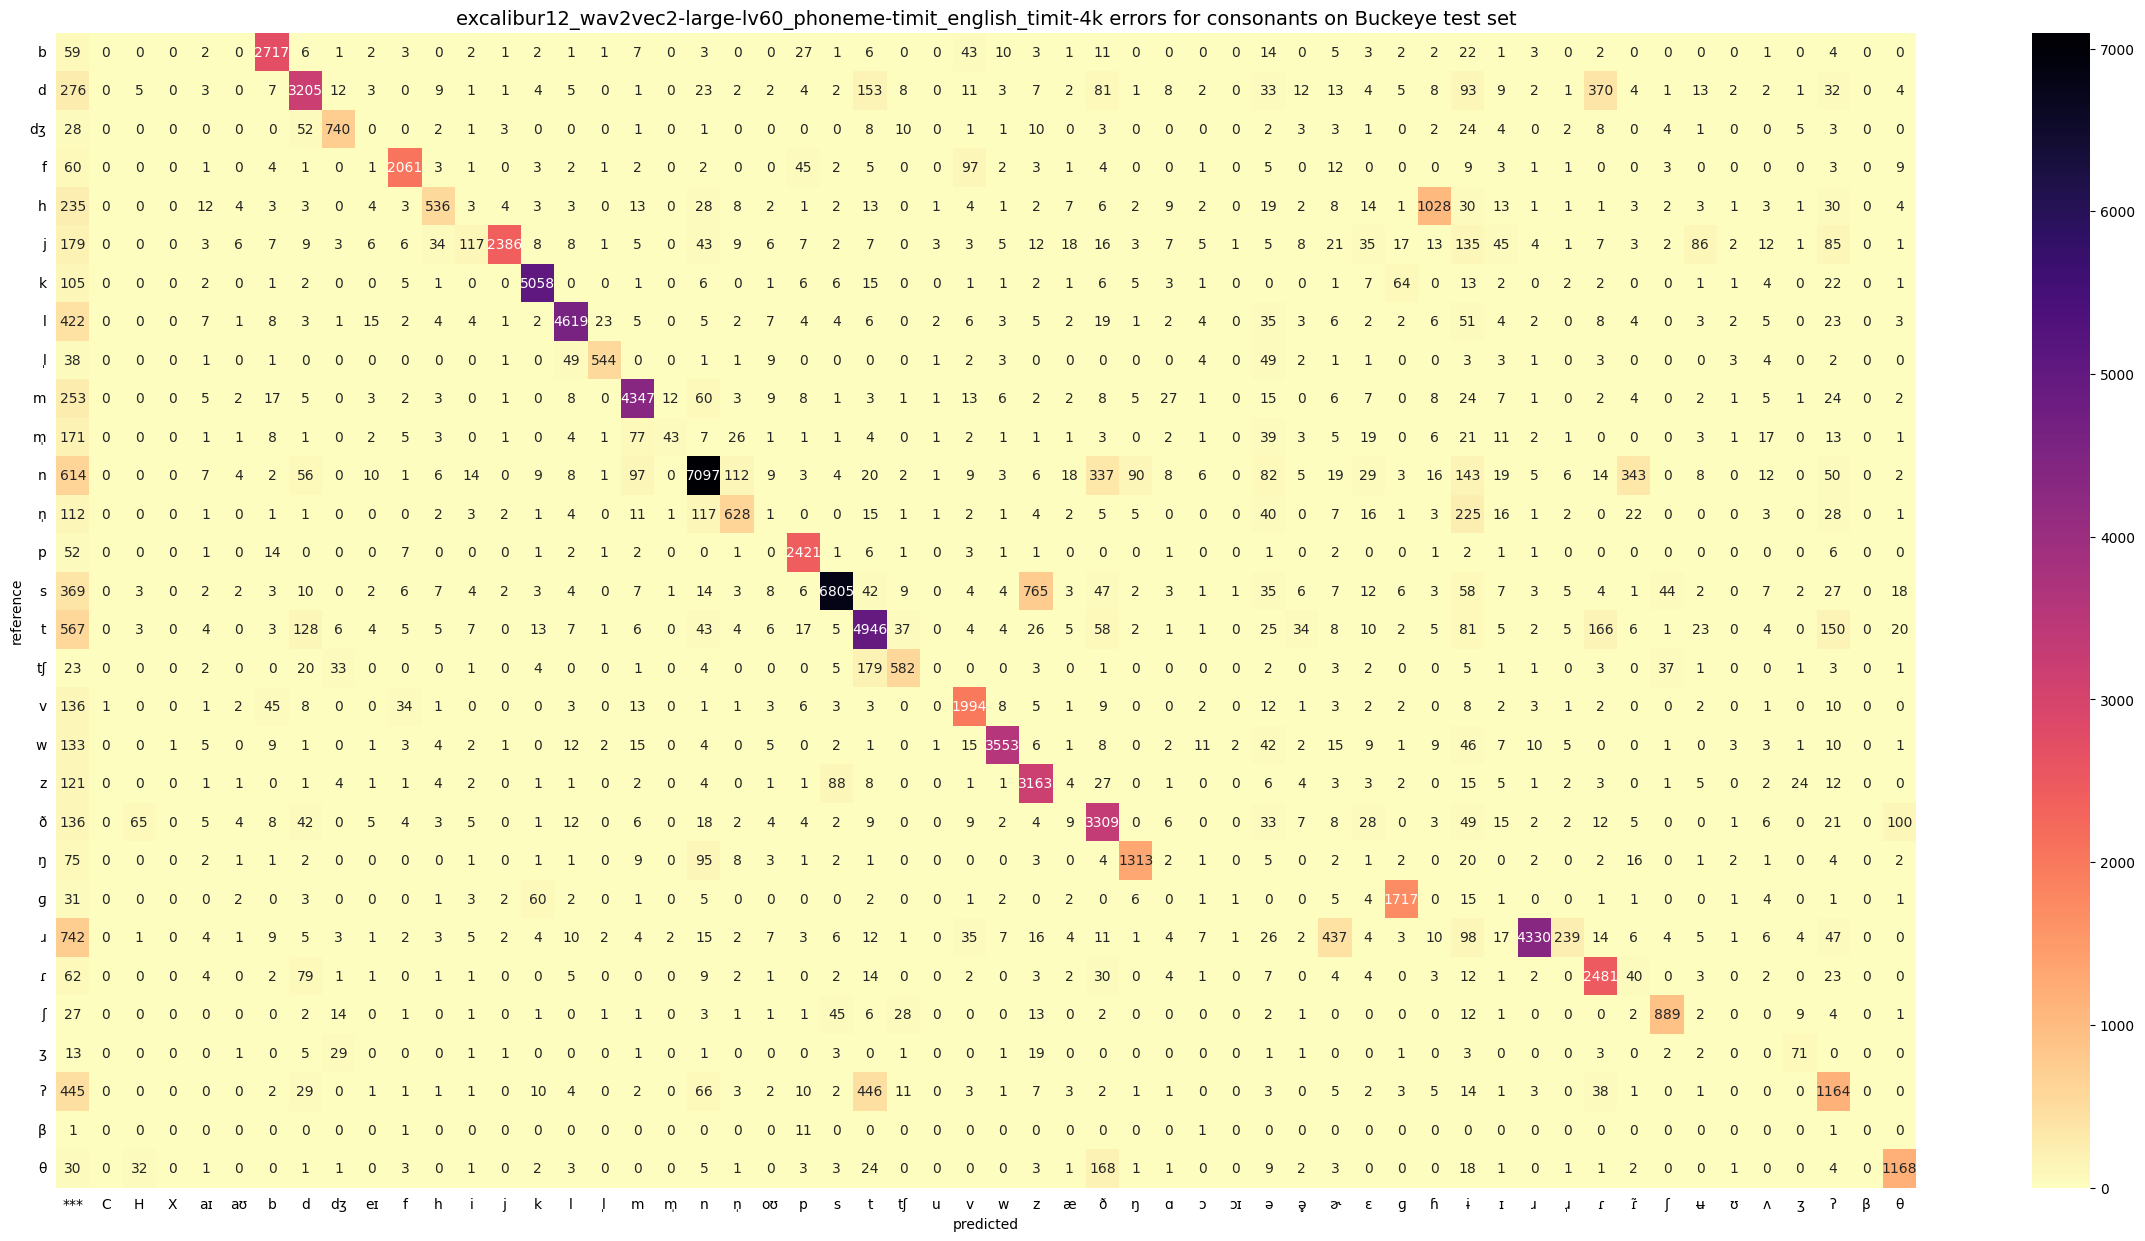

In [17]:
plt.clf()
desired_models_for_conf_matrix = [
    "full_dataset_train_3",
    "train_duration_20000_samples_3",
    "openai_whisper-medium.en_to_epitran",
    "allosaurus_eng2102_eng",
    "facebook_wav2vec2-lv-60-espeak-cv-ft",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k"
]
for mn in desired_models_for_conf_matrix:
    for (label, restriction) in [("vowels", BUCKEYE_VOWELS), ("consonants", BUCKEYE_CONSONANTS)]:
        if mn == "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns":
            figsize = (55, 20)
        elif mn ==    "facebook_wav2vec2-lv-60-espeak-cv-ft":
            figsize = (35, 15)
        else:
            figsize = (30,15)
        plot_token_confusion_matrix(conf_matrices[mn], f"{mn} errors for {label} on Buckeye test set", reference_keys=restriction, figsize=figsize, fmt='.0f', cmap="magma_r")

# Vocabulary item counts in pivot table
Get vocabulary item counts for each model and display them in a pivot table that helps you analyze differences between models. 

In [18]:
token_count_dfs = []
for model_name in desired_models_for_conf_matrix:
    matrix = conf_matrices[model_name]
    print("Model name:", model_name)
    token_count_df = matrix.groupby("predicted")["count"].sum().reset_index()
    token_count_df["model_name"] = model_name
    token_count_dfs.append(token_count_df)

full_token_count_df = pd.concat(token_count_dfs)
full_token_count_df = full_token_count_df[(full_token_count_df["count"] > 0) & (full_token_count_df["predicted"] != EPS)]
display(full_token_count_df.head())


Model name: full_dataset_train_3
Model name: train_duration_20000_samples_3
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k


predicted  count            model_name
7         aɪ   3826  full_dataset_train_3
8         aʊ    826  full_dataset_train_3
11         b   3059  full_dataset_train_3
12         d   4256  full_dataset_train_3
13        dʒ    878  full_dataset_train_3

In [19]:
token_count_pivoted = full_token_count_df.pivot(columns="model_name", index="predicted", values="count")
display(token_count_pivoted)

model_name  allosaurus_eng2102_eng  \
predicted                            
C                              NaN   
H                              NaN   
X                              NaN   
a                           5956.0   
aɪ                            12.0   
aʊ                             1.0   
aː                             NaN   
aːː                            NaN   
ãɪ̃                           NaN   
ä                             NaN   
äː                            NaN   
a͡                             NaN   
a͡a                            NaN   
a͡h                            NaN   
a͡i                            NaN   
a͡n                            NaN   
a͡p                            NaN   
a͡t                            NaN   
a͡ɔ                            NaN   
a͡ɕ                            NaN   
a͡ɛ                            NaN   
a͡ɨ                            NaN   
a͡ʂ                            NaN   
b                           3091.0   
bː                             NaN   
b͡ɨ                            NaN   
c                              NaN   
d                           5935.0   
dʒ                             NaN   
dː                             NaN   
d̪                             NaN   
d͡                             NaN   
d͡a                            NaN   
d͡k                            NaN   
d͡l                            NaN   
d͡t                            NaN   
d͡t͡s                          NaN   
d͡z                            NaN   
d͡zː                           NaN   
d͡ɨ                            NaN   
d͡ʂ                            NaN   
d͡ʑ                            NaN   
d͡ʑː                           NaN   
d͡ʒ                          830.0   
d͡ʒː                           NaN   
e                           2977.0   
eɪ                             9.0   
eː                             NaN   
ẽɪ̃                           NaN   
e̞                             NaN   
e̞ː                            NaN   
e͡                             NaN   
f                           2084.0   
fː                             NaN   
f͡ɨ                            NaN   
g                              NaN   
gː                             NaN   
h                           2009.0   
hː                             NaN   
i                           5747.0   
iː                             NaN   
iːː                            NaN   
iː͡i                           NaN   
ĩ                             NaN   
i̪                             NaN   
i͡a                            NaN   
i͡i                            NaN   
i͡n                            NaN   
i͡s                            NaN   
i͡uː                           NaN   
i͡w                            NaN   
i͡ɛ                            NaN   
i͡ɨ                            NaN   
i͡ʂ                            NaN   
i͡ː                            NaN   
j                          10720.0   
jː                             NaN   
j͡a                            NaN   
j͡o                            NaN   
j͡ɛ                            NaN   
k                           5409.0   
kʲ                             NaN   
kː                             NaN   
k͡r                            NaN   
l                           5772.0   
lː                             NaN   
l̩                             NaN   
m                           4295.0   
mː                             NaN   
m̩                             NaN   
m͡a                            NaN   
m͡ʂ                            NaN   
n                          11110.0   
nː                             NaN   
nːː                            NaN   
n̩                             NaN   
n̪                             NaN   
n͡a                            NaN   
n͡aː                           NaN   
n͡eː                           NaN   
n͡i                            NaN   
n͡j                            NaN   
n͡n                            NaN   
n͡r       

In [20]:
token_count_pivoted.to_csv(TOKEN_ANALYSIS_OUTPUT)